In [1]:
pwd

'/kaggle/working'

# Dependency Installation

In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.6.0+cu124
12.4


In [3]:
# ✅ Install PyTorch Geometric & related packages for PyTorch 2.6.0 + CUDA 12.4
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
  -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:00


In [4]:
!pip install torch-geometric-temporal --no-deps


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 3.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch_geometric
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
import matplotlib.pyplot as plt
import yaml


# Data

In [6]:
import numpy as np
import pandas as pd
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch_geometric
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
import matplotlib.pyplot as plt
import yaml


config_file_path = r"/kaggle/input/acs-history-sum/config.yaml"
config_file_path = Path(config_file_path)

chicago_acs5_history_sum_df_file_path = r"/kaggle/input/acs-history-sum/acs_history_sum_acs_survey_acs5_geography_unit_block_group.csv"
chicago_acs5_history_sum_df_file_path = Path(chicago_acs5_history_sum_df_file_path)

adj_matrix_file_path = r"/kaggle/input/acs-history-sum/acs_network_adj_matrix.csv"
adj_matrix_file_path = Path(adj_matrix_file_path)

category_names = [
    "Total Population by Race",
    "Total Housing Units by Race",
    "Median household income by Race",
    "Total Median Household Income"
]

race_names = [
    "White",
    "Black or African American",
    "American Indian and Alaska Native",
    "Asian",
    "Native Hawaiian and Other Pacific Islander",
    "Other Race",
    # "Two or More Races"
]

train_test_split_year = 2020


def filter_sum_df(chicago_acs5_history_sum_df, zero_threshold=0):
    # Step 1: Count zeros per variable_name
    zero_counts = chicago_acs5_history_sum_df.groupby("variable_name")["value_sum"].apply(lambda x: (x == 0).sum())

    # Step 2: Get variable_names with fewer zeros than threshold
    valid_variables = zero_counts[zero_counts <= zero_threshold].index
    removed_variables = zero_counts[zero_counts > zero_threshold].index

    # Step 3: Filter the DataFrame
    filtered_df = chicago_acs5_history_sum_df[chicago_acs5_history_sum_df["variable_name"].isin(valid_variables)]
    # removed_descriptions = chicago_acs5_history_sum_df[chicago_acs5_history_sum_df["variable_name"].isin(removed_variables)]["description"].unique()

    return filtered_df, removed_variables

def verify_unique_variable_names(acs_config):
    variable_names = []

    categories = acs_config["categories"]

    for category_info in categories:
        category_name = category_info["category_name"]
        items = category_info["items"]

        for item in items:
            description = item["description"]
            variable_name = item["variable_name"]
            assert variable_name not in variable_names, variable_name

            variable_names.append(variable_name)

    print("len(variable_names):", len(variable_names))


def get_variable_infos(acs_config,
                       category_names):
    variable_infos = []

    lower_case_category_names = [category_name.lower() for
        category_name in category_names]

    categories = acs_config["categories"]

    for category_info in categories:
        category_name = category_info["category_name"]
        items = category_info["items"]

        if category_name.lower() not in lower_case_category_names:
            continue

        category_idx = lower_case_category_names.index(category_name.lower())
        matched_category_name = category_names[category_idx]

        if matched_category_name == category_names[-1]:
            for item in items:
                description = item["description"]
                variable_name = item["variable_name"]
                variable_info = {
                    "category_name": matched_category_name,
                    "race_name": "",
                    "description": description,
                    "variable_name": variable_name
                }

                variable_infos.append(variable_info)

            continue

        for item in items:
            description = item["description"]
            variable_name = item["variable_name"]

            matched_race_names = []

            for race_name in race_names:
                if race_name.lower() in description.lower():
                    matched_race_names.append(race_name)

            assert len(matched_race_names) <= 1, description

            if matched_race_names:
                matched_race_name = matched_race_names[0]

                variable_info = {
                    "category_name": matched_category_name,
                    "race_name": matched_race_name,
                    "description": description,
                    "variable_name": variable_name
                }

                variable_infos.append(variable_info)

    variable_infos_df = pd.DataFrame(variable_infos)

    return variable_infos_df


with open(config_file_path, 'r') as file:
    config_dict = yaml.safe_load(file)

verify_unique_variable_names(config_dict["history"]["acs"])

variable_infos_df = get_variable_infos(config_dict["history"]["acs"],
                       category_names)

chicago_acs5_history_sum_df = pd.read_csv(chicago_acs5_history_sum_df_file_path)
filtered_sum_df, removed_variables = filter_sum_df(chicago_acs5_history_sum_df)

adj_matrix_df = pd.read_csv(adj_matrix_file_path)
adj_matrix = adj_matrix_df.to_numpy()


acs_config = config_dict["history"]["acs"]

start_year = acs_config["start_year"]
end_year = acs_config["end_year"]
area_numbers = sorted(chicago_acs5_history_sum_df["area_number"].unique())
features = []
targets = []

for year in range(start_year, end_year + 1):
    for area_number in area_numbers:
        year_mask = filtered_sum_df["year"] == year
        area_mask = filtered_sum_df["area_number"] == area_number
        area_sum_df = filtered_sum_df[year_mask & area_mask]

        for category_name in category_names:
            if category_name == category_names[-1]:
                variable_mask = (variable_infos_df["category_name"] == category_name)
                cat_variable_infos_df = variable_infos_df[variable_mask]

                for cat_variable_info_idx, cat_variable_info_row in cat_variable_infos_df.iterrows():
                    variable_name = cat_variable_info_row["variable_name"]
                    # print("variable_name:", variable_name)
                    item_sum_df = area_sum_df[area_sum_df["variable_name"] == variable_name]
                    # print("item_sum_df:", item_sum_df)

                    if item_sum_df.empty:
                        continue

                    value_sum = item_sum_df["value_sum"].item()

                    feature = {
                        "area_number": area_number,
                        "year": year,
                        "category_name": category_name,
                        "race_name": "",
                        "variable_name": variable_name,
                        "value_sum": value_sum
                    }

                    features.append(feature)
                    targets.append(feature)

                continue


            for race_name in race_names:
                variable_mask = (variable_infos_df["category_name"] == category_name) & (variable_infos_df["race_name"] == race_name)
                race_variable_infos_df = variable_infos_df[variable_mask]

                variable_name = race_variable_infos_df["variable_name"]
                assert len(variable_name) <= 1, variable_name

                if len(variable_name) == 1:
                    item_sum_df = area_sum_df[area_sum_df["variable_name"] == variable_name.item()]
                    assert len(item_sum_df) <= 1, (item_sum_df, race_name)

                    if len(item_sum_df) == 1:
                        value_sum = item_sum_df["value_sum"].item()

                        feature = {
                            "area_number": area_number,
                            "year": year,
                            "category_name": category_name,
                            "race_name": race_name,
                            "variable_name": variable_name,
                            "value_sum": value_sum
                        }

                        features.append(feature)

features_df = pd.DataFrame(features)
targets_df = pd.DataFrame(targets)


len(variable_names): 87


In [7]:
features_df.describe()

,area_number,year,value_sum
count,4158.000000,4158.000000,4.158000e+03
mean,39.000000,2019.000000,9.071373e+05
std,22.228784,2.582299,1.764155e+06
min,1.000000,2015.000000,2.400000e+01
25%,20.000000,2017.000000,5.387000e+03
50%,39.000000,2019.000000,2.238050e+04
75%,58.000000,2021.000000,1.218234e+06
max,77.000000,2023.000000,1.193194e+07


In [8]:
features_df["race_name"].unique()

array(['White', 'Black or African American', ''], dtype=object)

In [9]:
features_df["category_name"].unique()

array(['Total Population by Race', 'Total Housing Units by Race',
       'Total Median Household Income'], dtype=object)

In [10]:
features_df.shape

(4158, 6)

# Code

Epoch 0, Train Loss: 0.1032, Test Loss: 0.0586
Epoch 20, Train Loss: 0.0271, Test Loss: 0.0276
Epoch 40, Train Loss: 0.0260, Test Loss: 0.0256
Epoch 60, Train Loss: 0.0241, Test Loss: 0.0238
Epoch 80, Train Loss: 0.0231, Test Loss: 0.0232
Epoch 100, Train Loss: 0.0226, Test Loss: 0.0226
Epoch 120, Train Loss: 0.0222, Test Loss: 0.0222
Epoch 140, Train Loss: 0.0217, Test Loss: 0.0220
Epoch 160, Train Loss: 0.0214, Test Loss: 0.0218
Epoch 180, Train Loss: 0.0212, Test Loss: 0.0217


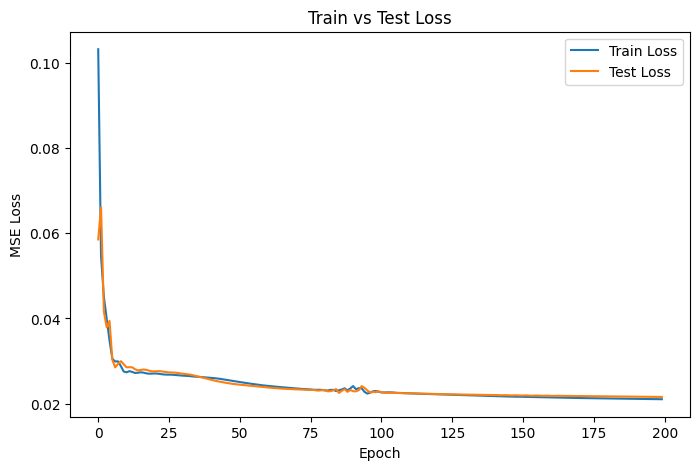

In [11]:

# Model
import numpy as np
import pandas as pd
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch_geometric
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


edge_row, edge_col = np.nonzero(adj_matrix)
edge_index = np.vstack([edge_row, edge_col])
edge_weight = adj_matrix[edge_row, edge_col]

# --- Setup Scalers ---
# Initialize separate scalers for features (X) and targets (y)
# We will fit these only on the training data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

input_features = []
gt_targets = []
train_mask = []
train_features_log = []
train_targets_log = []

for year in range(start_year, train_test_split_year):
    curr_year_features = features_df[features_df["year"] == year]["value_sum"].to_numpy().astype(np.float32)
    next_year_targets = targets_df[targets_df["year"] == (year + 1)]["value_sum"].to_numpy().astype(np.float32)

    # input_feature = curr_year_features.reshape(len(area_numbers), -1)
    # input_features.append(input_feature)

    # gt_target = next_year_targets.reshape(len(area_numbers), -1)
    # gt_targets.append(gt_target)

    # Apply Log1p transformation to both features and targets
    curr_year_features_log = np.log1p(curr_year_features)
    next_year_targets_log = np.log1p(next_year_targets)

    # Collect only the training data for fitting the scaler
    if year <= train_test_split_year:
        # Reshape to 2D for MinMaxScaler (n_samples, n_features)
        train_features_log.append(curr_year_features_log.reshape(-1, 1))
        train_targets_log.append(next_year_targets_log.reshape(-1, 1))


# Concatenate all training snapshots
train_features_combined = np.concatenate(train_features_log, axis=0)
train_targets_combined = np.concatenate(train_targets_log, axis=0)
# --- 2. Fit Scalers on Training Data ---
feature_scaler.fit(train_features_combined)
target_scaler.fit(train_targets_combined)

# --- 3. Second Pass: Apply Log1p and Scale to All Data ---
for year in range(start_year, end_year):
    curr_year_features = features_df[features_df["year"] == year]["value_sum"].to_numpy().astype(np.float32)
    next_year_targets = targets_df[targets_df["year"] == (year + 1)]["value_sum"].to_numpy().astype(np.float32)

    # a. Apply Log1p
    curr_year_features_log = np.log1p(curr_year_features)
    next_year_targets_log = np.log1p(next_year_targets)

    # b. Reshape for scaling
    curr_year_features_reshaped = curr_year_features_log.reshape(-1, 1)
    next_year_targets_reshaped = next_year_targets_log.reshape(-1, 1)

    # c. Apply Scaling (using the fitted scalers)
    scaled_feature = feature_scaler.transform(curr_year_features_reshaped)
    scaled_target = target_scaler.transform(next_year_targets_reshaped)

    # d. Final reshape to [Number of Nodes, 1] for StaticGraphTemporalSignal
    input_feature = scaled_feature.reshape(len(area_numbers), -1)
    input_features.append(input_feature)

    gt_target = scaled_target.reshape(len(area_numbers), -1)
    gt_targets.append(gt_target)

    train_mask.append(year <= train_test_split_year)


dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=input_features,
    targets=gt_targets
)

train_mask = np.array(train_mask)
test_mask = ~train_mask


class IncomeTGCN(nn.Module):
    def __init__(self, node_features, hidden_size, out_features):
        super(IncomeTGCN, self).__init__()
        self.tgcn = TGCN(node_features, hidden_size)
        self.linear = nn.Linear(hidden_size, out_features)

    def forward(self, x, edge_index, edge_weight=None):
        h = self.tgcn(x, edge_index, edge_weight)
        out = self.linear(h)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IncomeTGCN(node_features=dataset[0].x.shape[1],
                   hidden_size=32,
                   out_features=dataset[0].y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop with train/test loss
train_losses = []
test_losses = []

model.train()

for epoch in range(200):
    loss_train_total = 0
    loss_test_total = 0

    model.train()

    for t, snapshot in enumerate(dataset):
        if train_mask[t]:
            # 1. Move the entire snapshot object to the GPU at once
            snapshot = snapshot.to(device)

            # 2. Access tensors via dot notation
            x = snapshot.x
            edge_index = snapshot.edge_index
            edge_weight = snapshot.edge_attr
            y = snapshot.y

            optimizer.zero_grad()
            y_hat = model(x, edge_index, edge_weight)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            loss_train_total += loss.item()

    model.eval()
    with torch.no_grad():
        for t, snapshot in enumerate(dataset):
            if test_mask[t]: # Only evaluate test snapshots
                snapshot = snapshot.to(device)
                y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                loss = criterion(y_hat, snapshot.y)
                loss_test_total += loss.item()

    train_losses.append(loss_train_total / max(1, sum(train_mask)))
    test_losses.append(loss_test_total / max(1, sum(test_mask)))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot train/test loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()


In [12]:
dataset[0]

Data(x=[77, 6], edge_index=[2, 394], edge_attr=[394], y=[77, 2])

Starting model evaluation on the LAST SNAPSHOT (index: 7)...
Collected predictions for 1 snapshot.
Data successfully inverse-transformed to original scale.

--- Evaluation Metrics (Unnormalized Scale for Last Snapshot) ---
Mean Squared Error (MSE):  2707397804032.0000
Root Mean Squared Error (RMSE): 1645417.2500
Mean Absolute Error (MAE): 1110442.3750
------------------------------------------


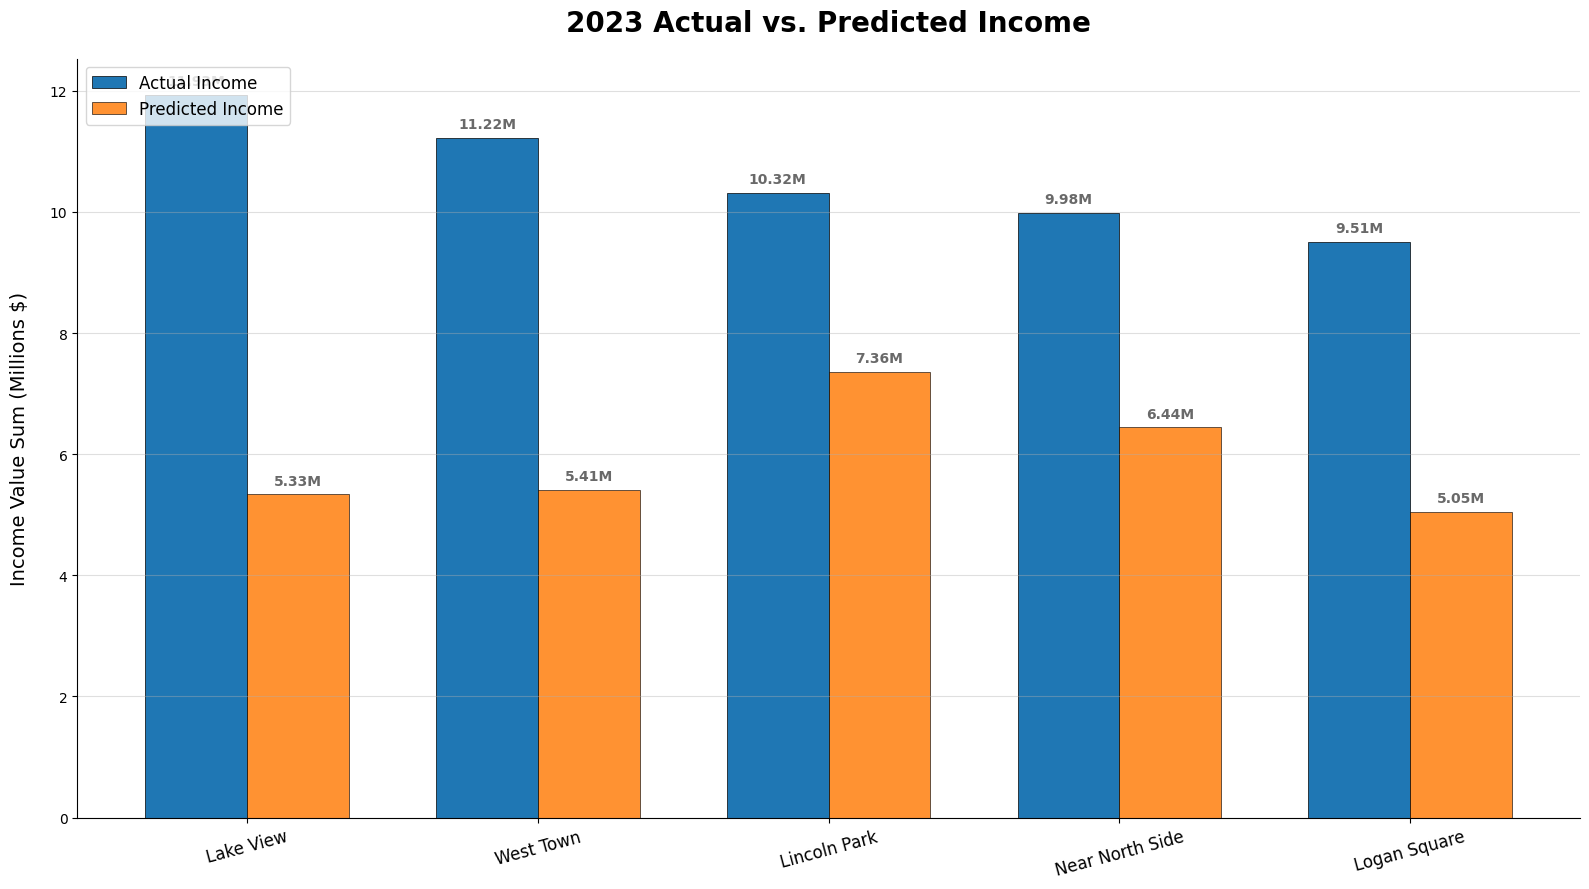

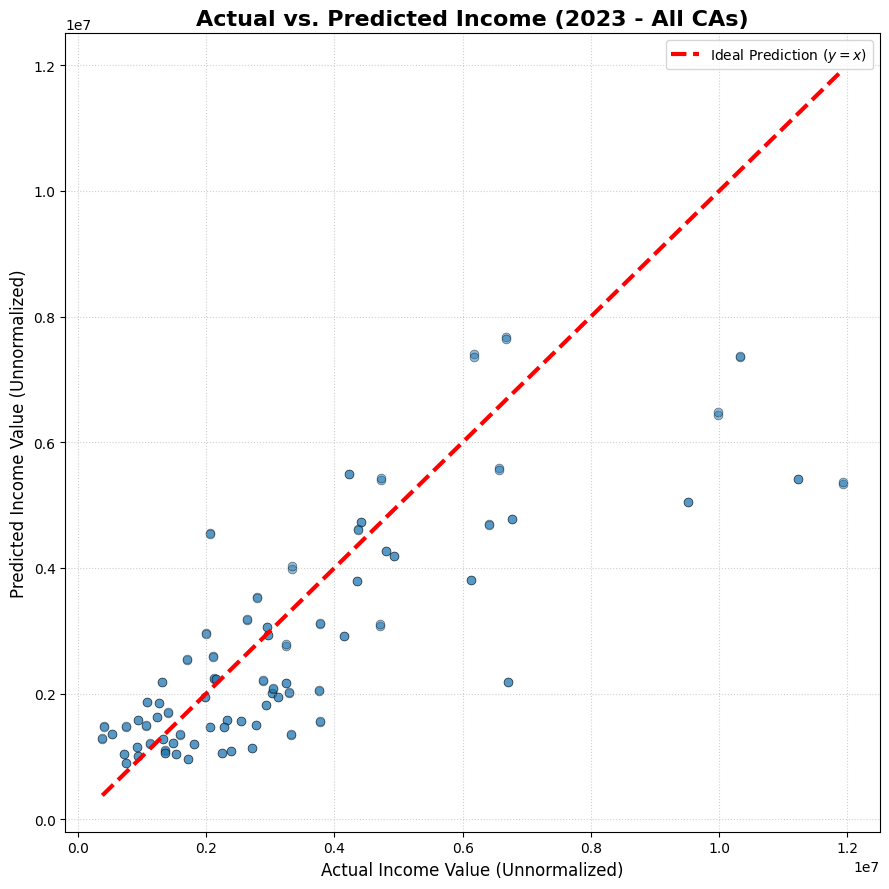

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- ASSUMPTIONS ---
# The following variables MUST be defined in your environment from previous steps:
# 1. model: The trained IncomeTGCN PyTorch model.
# 2. dataset: The StaticGraphTemporalSignal object containing all data.
# 3. test_mask: The boolean NumPy array indicating test snapshots.
# 4. device: The device ('cuda' or 'cpu') the model is running on.
# 5. target_scaler: The fitted sklearn MinMaxScaler used for targets.
# 6. area_numbers: A list/array of area identifiers (used for visualization labels).
# --------------------

# Set the model to evaluation mode
model.eval()

preds = []
labels = []

# --- IDENTIFY THE LAST SNAPSHOT INDEX ---
# The user wants to evaluate ONLY the last available time step (snapshot).
# Using len(dataset) to ensure compatibility if dataset.features is not available or is structured differently
last_year_index = len(dataset.features) - 1 
# We will use this index to filter the prediction loop.

print(f"Starting model evaluation on the LAST SNAPSHOT (index: {last_year_index})...")

# --- 1. Prediction Loop ---
# Collect predictions and ground truth values ONLY for the last snapshot
for t, snapshot in enumerate(dataset):
    # Only process the last snapshot
    if t == last_year_index:
        # Move snapshot to the correct device
        snapshot = snapshot.to(device)

        # Disable gradient calculations during evaluation
        with torch.no_grad():
            x = snapshot.x
            edge_index = snapshot.edge_index
            edge_weight = snapshot.edge_attr
            y = snapshot.y

            y_hat = model(x, edge_index, edge_weight)

            # Store results
            preds.append(y_hat)
            labels.append(y)
        break # Stop after processing the last snapshot for efficiency

print(f"Collected predictions for {len(preds)} snapshot.")

# --- 2. Data Preparation for Inverse Transform ---

# Concatenate all tensors into single NumPy arrays, moving them to CPU first
# Since only one snapshot is used, this concatenation results in shape [Num_Nodes, Output_Timesteps]
Y_pred_scaled = torch.cat(preds, dim=0).cpu().detach().numpy()
Y_true_scaled = torch.cat(labels, dim=0).cpu().detach().numpy()

# --- 3. Inverse Transformation ---

# Inverse transform scaling (MinMax)
Y_pred_log = target_scaler.inverse_transform(Y_pred_scaled)
Y_true_log = target_scaler.inverse_transform(Y_true_scaled)

# Inverse transform Log1p (np.expm1) to get real, unnormalized values
Y_pred = np.expm1(Y_pred_log)
Y_true = np.expm1(Y_true_log)

# Clean up any potential negative floating-point artifacts after expm1
Y_pred[Y_pred < 0] = 0

print("Data successfully inverse-transformed to original scale.")

# --- 4. Metric Calculation ---

# Note: Metrics are now calculated over all nodes for this single time step.
mse = mean_squared_error(Y_true, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_true, Y_pred)

print("\n--- Evaluation Metrics (Unnormalized Scale for Last Snapshot) ---")
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("------------------------------------------")

# --- 5. Visualization for Specific Communities (Combined Plot) ---

# Define the target communities and create a mapping from Area ID to Node Index
target_communities = {
    "Lake View": 6,
    "West Town": 24,
    "Lincoln Park": 7,
    "Near North Side": 8,
    "Logan Square": 22
}

# Create a mapping from area number (ID) to index for quick lookup
area_to_index = {id: i for i, id in enumerate(area_numbers)}

plot_data = []
for name, id in target_communities.items():
    if id in area_to_index:
        plot_data.append({
            'name': name,
            'id': id,
            'index': area_to_index[id]
        })
    else:
        print(f"Warning: Area number {id} ({name}) not found in area_numbers list. Skipping.")

if not plot_data:
    print("Error: No target communities were found in the dataset's area_numbers.")
else:
    prediction_horizon_index = 0 # Look at the prediction for the immediate next time step (t+1)

    # 1. Extract data for the single plot
    community_names = [data['name'] for data in plot_data]
    actual_values = []
    predicted_values = []

    for data in plot_data:
        node_index_to_plot = data['index']
        # Y_true and Y_pred are of shape [Num_Nodes, Output_Timesteps]
        actual_values.append(Y_true[node_index_to_plot, prediction_horizon_index])
        predicted_values.append(Y_pred[node_index_to_plot, prediction_horizon_index])
    
    # Convert values to Millions ($M)
    M_FACTOR = 1_000_000.0
    actual_values = [v / M_FACTOR for v in actual_values]
    predicted_values = [v / M_FACTOR for v in predicted_values]

    # --- Start Plot Styling ---
    # Removed plt.style.use('ggplot') for a cleaner default look
    
    # 2. Setup the plot parameters
    x = np.arange(len(community_names))  # the label locations
    width = 0.35  # the width of the bars
    
    # Define custom, professional colors
    COLOR_ACTUAL = '#1f77b4' # Deep Blue
    COLOR_PREDICTED = '#ff7f0e' # Orange/Red
    
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # Set figure and axes background to white
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # 3. Create the grouped bars with enhanced aesthetics
    rects1 = ax.bar(x - width/2, actual_values, width, 
                    label='Actual Income', 
                    color=COLOR_ACTUAL,
                    edgecolor='black',
                    linewidth=0.5)
    
    rects2 = ax.bar(x + width/2, predicted_values, width, 
                    label='Predicted Income', 
                    color=COLOR_PREDICTED, 
                    alpha=0.85,
                    edgecolor='black',
                    linewidth=0.5)

    # 4. Add labels, title, and custom x-axis tick labels
    ax.set_title(f"2023 Actual vs. Predicted Income", 
                 fontsize=20, 
                 fontweight='bold', 
                 pad=20)
    ax.set_ylabel("Income Value Sum (Millions $)", fontsize=14, labelpad=15)
    
    ax.set_xticks(x)
    ax.set_xticklabels(community_names, 
                       rotation=15, 
                       ha="center", 
                       fontsize=12)
    
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(axis='y', linestyle='-', alpha=0.4, zorder=0) # Enhance gridlines
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 5. Function to attach a text label above each bar (improved positioning)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}M',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # Slight vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        fontsize=10, 
                        fontweight='bold',
                        color='dimgray')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

# --- Optional: Scatter plot of Actual vs. Predicted for all data points (Styled) ---
fig_scatter, ax_scatter = plt.subplots(figsize=(9, 9))
fig_scatter.patch.set_facecolor('white') # Figure background
ax_scatter.set_facecolor('white')       # Axes background

ax_scatter.scatter(Y_true, Y_pred, alpha=0.5, s=40, color=COLOR_ACTUAL, edgecolors='black', linewidths=0.5)
ax_scatter.plot([Y_true.min(), Y_true.max()], [Y_true.min(), Y_true.max()], 'r--', lw=3, label="Ideal Prediction ($y=x$)")
ax_scatter.set_title("Actual vs. Predicted Income (2023 - All CAs)", fontsize=16, fontweight='bold')
ax_scatter.set_xlabel("Actual Income Value (Unnormalized)", fontsize=12)
ax_scatter.set_ylabel("Predicted Income Value (Unnormalized)", fontsize=12)
ax_scatter.legend(fontsize=10)
ax_scatter.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.savefig("actual_vs_predicted_income.pdf", bbox_inches='tight')

plt.show()


--- Evaluation Metrics (Last Snapshot) ---
MSE:  2707397804032.0000
RMSE: 1645417.2500
MAE:  1110442.3750
------------------------------------------


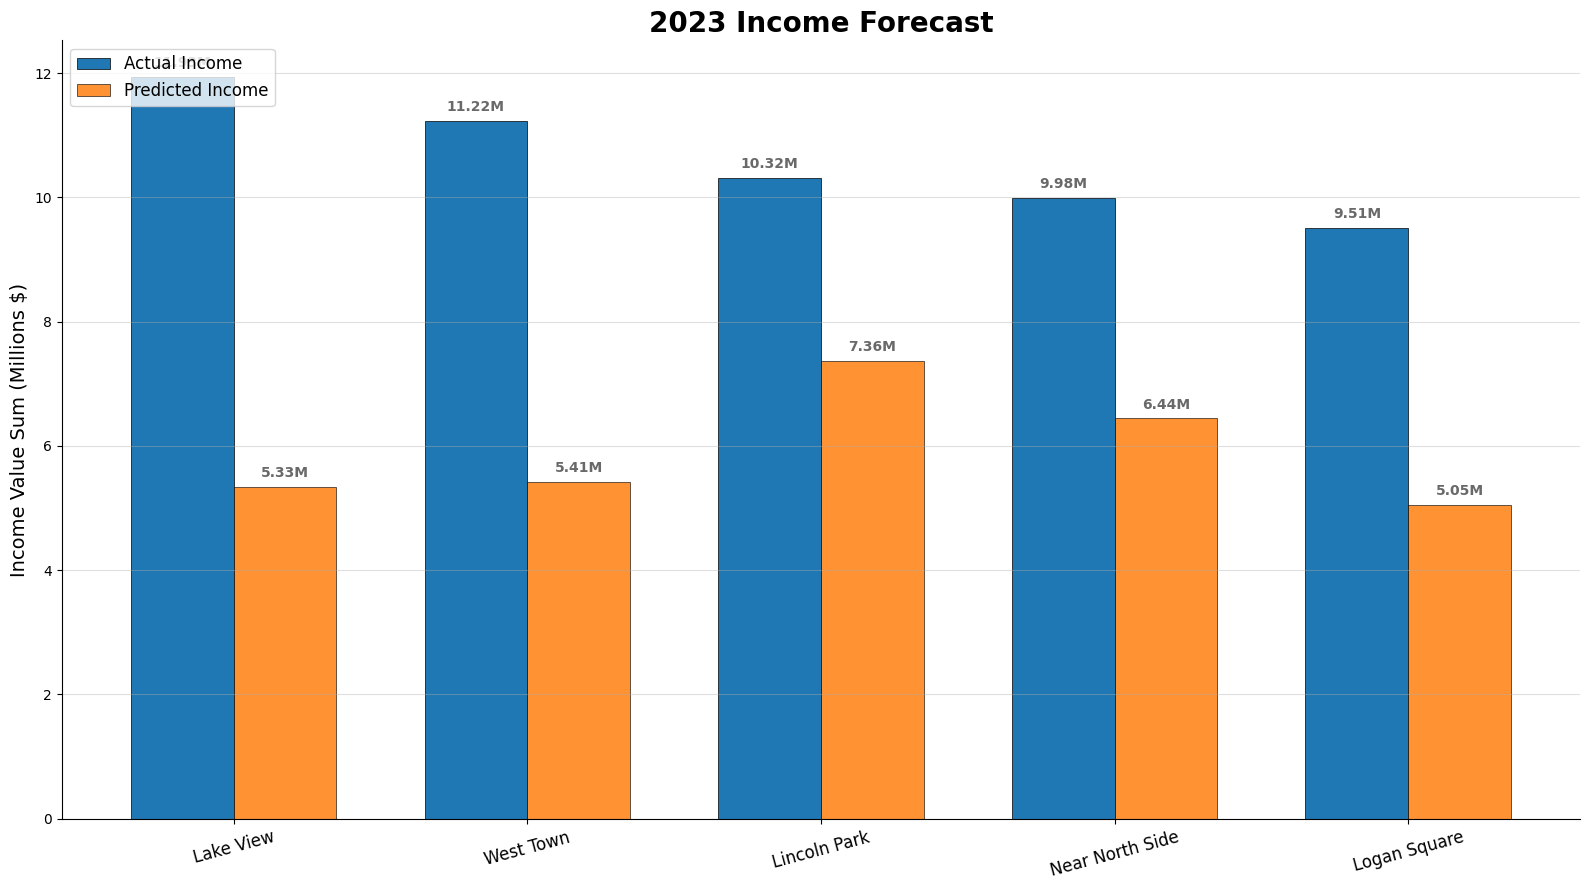

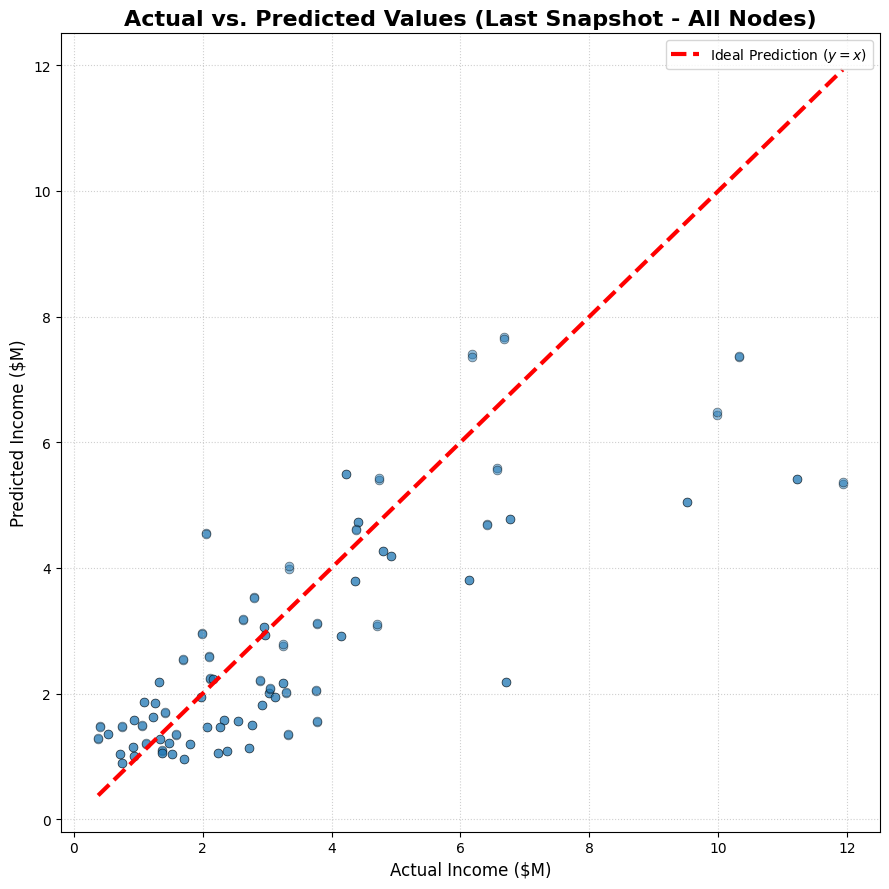

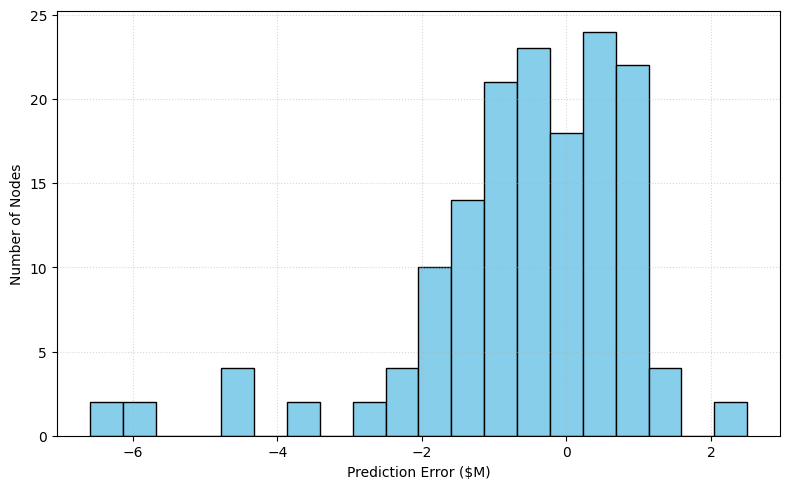

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- ASSUMPTIONS ---
# 1. model: trained IncomeTGCN PyTorch model
# 2. dataset: StaticGraphTemporalSignal object
# 3. test_mask: boolean array indicating test snapshots
# 4. device: 'cuda' or 'cpu'
# 5. target_scaler: fitted MinMaxScaler for targets
# 6. area_numbers: list/array of node identifiers
# --------------------

# Set model to eval mode
model.eval()

preds = []
labels = []

# --- Identify the last snapshot index ---
last_year_index = len(dataset.features) - 1

# --- Collect predictions for last snapshot ---
for t, snapshot in enumerate(dataset):
    if t == last_year_index:
        snapshot = snapshot.to(device)
        with torch.no_grad():
            x = snapshot.x
            edge_index = snapshot.edge_index
            edge_weight = snapshot.edge_attr
            y = snapshot.y
            y_hat = model(x, edge_index, edge_weight)

            preds.append(y_hat)
            labels.append(y)
        break

# --- Prepare data for inverse transform ---
Y_pred_scaled = torch.cat(preds, dim=0).cpu().detach().numpy()
Y_true_scaled = torch.cat(labels, dim=0).cpu().detach().numpy()

# --- Inverse scaling ---
Y_pred_log = target_scaler.inverse_transform(Y_pred_scaled)
Y_true_log = target_scaler.inverse_transform(Y_true_scaled)

# --- Inverse log1p transform ---
Y_pred = np.expm1(Y_pred_log)
Y_true = np.expm1(Y_true_log)

# Ensure no negative values after inverse transform
Y_pred[Y_pred < 0] = 0

# --- Evaluation metrics ---
mse = mean_squared_error(Y_true, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_true, Y_pred)

print("\n--- Evaluation Metrics (Last Snapshot) ---")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print("------------------------------------------")

# --- Plot bar chart for key communities ---
target_communities = {
    "Lake View": 6,
    "West Town": 24,
    "Lincoln Park": 7,
    "Near North Side": 8,
    "Logan Square": 22
}

area_to_index = {id: i for i, id in enumerate(area_numbers)}

plot_data = []
for name, id in target_communities.items():
    if id in area_to_index:
        plot_data.append({'name': name, 'id': id, 'index': area_to_index[id]})

prediction_horizon_index = 0  # first timestep

community_names = [d['name'] for d in plot_data]
actual_values = [Y_true[d['index'], prediction_horizon_index] for d in plot_data]
predicted_values = [Y_pred[d['index'], prediction_horizon_index] for d in plot_data]

# Convert to Millions ($M)
M_FACTOR = 1_000_000.0
actual_values = [v / M_FACTOR for v in actual_values]
predicted_values = [v / M_FACTOR for v in predicted_values]

# Plot bar chart
x = np.arange(len(community_names))
width = 0.35
COLOR_ACTUAL = '#1f77b4'
COLOR_PREDICTED = '#ff7f0e'

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x - width/2, actual_values, width, label='Actual Income', color=COLOR_ACTUAL, edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, predicted_values, width, label='Predicted Income', color=COLOR_PREDICTED, alpha=0.85, edgecolor='black', linewidth=0.5)

ax.set_title("2023 Income Forecast", fontsize=20, fontweight='bold')
ax.set_ylabel("Income Value Sum (Millions $)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(community_names, rotation=15, ha="center", fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', linestyle='-', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}M',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold', color='dimgray')

# Attach labels
autolabel(ax.patches[:len(community_names)])
autolabel(ax.patches[len(community_names):])

plt.tight_layout()
plt.show()

# --- Scatter plot for all nodes ---
fig_scatter, ax_scatter = plt.subplots(figsize=(9, 9))
ax_scatter.scatter(Y_true / M_FACTOR, Y_pred / M_FACTOR, alpha=0.5, s=40, color=COLOR_ACTUAL, edgecolors='black', linewidths=0.5)
ax_scatter.plot([Y_true.min() / M_FACTOR, Y_true.max() / M_FACTOR],
                [Y_true.min() / M_FACTOR, Y_true.max() / M_FACTOR],
                'r--', lw=3, label="Ideal Prediction ($y=x$)")
ax_scatter.set_title("Actual vs. Predicted Values (Last Snapshot - All Nodes)", fontsize=16, fontweight='bold')
ax_scatter.set_xlabel("Actual Income ($M)", fontsize=12)
ax_scatter.set_ylabel("Predicted Income ($M)", fontsize=12)
ax_scatter.legend(fontsize=10)
ax_scatter.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Prediction Error Histogram ---
errors = ((Y_pred - Y_true) / M_FACTOR).flatten()  # ensure 1D

fig, ax = plt.subplots(figsize=(8,5))

fig.patch.set_facecolor('white')  # figure background
# Set background colors
ax.set_facecolor('white')          # axes background

# Plot histogram
ax.hist(errors, bins=20, color='skyblue', edgecolor='black')

# Labels and title
ax.set_xlabel("Prediction Error ($M)")
ax.set_ylabel("Number of Nodes")
# ax.set_title("Distribution of Prediction Errors")

# Grid
ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch_geometric
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
import matplotlib.pyplot as plt
import yaml


config_file_path = r"/kaggle/input/acs-history-sum/config.yaml"
config_file_path = Path(config_file_path)

chicago_acs5_history_sum_df_file_path = r"/kaggle/input/acs-history-sum/acs_history_sum_acs_survey_acs5_geography_unit_block_group.csv"
chicago_acs5_history_sum_df_file_path = Path(chicago_acs5_history_sum_df_file_path)

adj_matrix_file_path = r"/kaggle/input/acs-history-sum/acs_network_adj_matrix.csv"
adj_matrix_file_path = Path(adj_matrix_file_path)

category_names = [
    "Total Population by Race",
    "Total Housing Units by Race",
    "Median household income by Race",
    "Total Median Household Income"
]

race_names = [
    "White",
    "Black or African American",
    "American Indian and Alaska Native",
    "Asian",
    "Native Hawaiian and Other Pacific Islander",
    "Other Race",
    # "Two or More Races"
]


communities = {
    "Lake View": 6,
    "West Town": 24,
    "Lincoln Park": 7,
    "Near North Side": 8,
    "Logan Square": 22
}

train_test_split_year = 2020


def filter_sum_df(chicago_acs5_history_sum_df, zero_threshold=0):
    # Step 1: Count zeros per variable_name
    zero_counts = chicago_acs5_history_sum_df.groupby("variable_name")["value_sum"].apply(lambda x: (x == 0).sum())

    # Step 2: Get variable_names with fewer zeros than threshold
    valid_variables = zero_counts[zero_counts <= zero_threshold].index
    removed_variables = zero_counts[zero_counts > zero_threshold].index

    # Step 3: Filter the DataFrame
    filtered_df = chicago_acs5_history_sum_df[chicago_acs5_history_sum_df["variable_name"].isin(valid_variables)]
    # removed_descriptions = chicago_acs5_history_sum_df[chicago_acs5_history_sum_df["variable_name"].isin(removed_variables)]["description"].unique()

    return filtered_df, removed_variables

def verify_unique_variable_names(acs_config):
    variable_names = []

    categories = acs_config["categories"]

    for category_info in categories:
        category_name = category_info["category_name"]
        items = category_info["items"]

        for item in items:
            description = item["description"]
            variable_name = item["variable_name"]
            assert variable_name not in variable_names, variable_name

            variable_names.append(variable_name)

    print("len(variable_names):", len(variable_names))


def get_variable_infos(acs_config,
                       category_names):
    variable_infos = []

    lower_case_category_names = [category_name.lower() for
        category_name in category_names]

    categories = acs_config["categories"]

    for category_info in categories:
        category_name = category_info["category_name"]
        items = category_info["items"]

        if category_name.lower() not in lower_case_category_names:
            continue

        category_idx = lower_case_category_names.index(category_name.lower())
        matched_category_name = category_names[category_idx]

        if matched_category_name == category_names[-1]:
            for item in items:
                description = item["description"]
                variable_name = item["variable_name"]
                variable_info = {
                    "category_name": matched_category_name,
                    "race_name": "",
                    "description": description,
                    "variable_name": variable_name
                }

                variable_infos.append(variable_info)

            continue

        for item in items:
            description = item["description"]
            variable_name = item["variable_name"]

            matched_race_names = []

            for race_name in race_names:
                if race_name.lower() in description.lower():
                    matched_race_names.append(race_name)

            assert len(matched_race_names) <= 1, description

            if matched_race_names:
                matched_race_name = matched_race_names[0]

                variable_info = {
                    "category_name": matched_category_name,
                    "race_name": matched_race_name,
                    "description": description,
                    "variable_name": variable_name
                }

                variable_infos.append(variable_info)

    variable_infos_df = pd.DataFrame(variable_infos)

    return variable_infos_df


with open(config_file_path, 'r') as file:
    config_dict = yaml.safe_load(file)

verify_unique_variable_names(config_dict["history"]["acs"])

variable_infos_df = get_variable_infos(config_dict["history"]["acs"],
                       category_names)

chicago_acs5_history_sum_df = pd.read_csv(chicago_acs5_history_sum_df_file_path)
filtered_sum_df, removed_variables = filter_sum_df(chicago_acs5_history_sum_df)

adj_matrix_df = pd.read_csv(adj_matrix_file_path)
adj_matrix = adj_matrix_df.to_numpy()


acs_config = config_dict["history"]["acs"]

start_year = acs_config["start_year"]
end_year = acs_config["end_year"]
area_numbers = sorted(chicago_acs5_history_sum_df["area_number"].unique())
features = []
targets = []

for year in range(start_year, end_year + 1):
    for area_number in area_numbers:
        year_mask = filtered_sum_df["year"] == year
        area_mask = filtered_sum_df["area_number"] == area_number
        area_sum_df = filtered_sum_df[year_mask & area_mask]

        for category_name in category_names:
            if category_name == category_names[-1]:
                variable_mask = (variable_infos_df["category_name"] == category_name)
                cat_variable_infos_df = variable_infos_df[variable_mask]

                for cat_variable_info_idx, cat_variable_info_row in cat_variable_infos_df.iterrows():
                    variable_name = cat_variable_info_row["variable_name"]
                    # print("variable_name:", variable_name)
                    item_sum_df = area_sum_df[area_sum_df["variable_name"] == variable_name]
                    # print("item_sum_df:", item_sum_df)

                    if item_sum_df.empty:
                        continue

                    value_sum = item_sum_df["value_sum"].item()

                    feature = {
                        "area_number": area_number,
                        "year": year,
                        "category_name": category_name,
                        "race_name": "",
                        "variable_name": variable_name,
                        "value_sum": value_sum
                    }

                    features.append(feature)
                    targets.append(feature)

                continue


            for race_name in race_names:
                variable_mask = (variable_infos_df["category_name"] == category_name) & (variable_infos_df["race_name"] == race_name)
                race_variable_infos_df = variable_infos_df[variable_mask]

                variable_name = race_variable_infos_df["variable_name"]
                assert len(variable_name) <= 1, variable_name

                if len(variable_name) == 1:
                    item_sum_df = area_sum_df[area_sum_df["variable_name"] == variable_name.item()]
                    assert len(item_sum_df) <= 1, (item_sum_df, race_name)

                    if len(item_sum_df) == 1:
                        value_sum = item_sum_df["value_sum"].item()

                        feature = {
                            "area_number": area_number,
                            "year": year,
                            "category_name": category_name,
                            "race_name": race_name,
                            "variable_name": variable_name,
                            "value_sum": value_sum
                        }

                        features.append(feature)

features_df = pd.DataFrame(features)
targets_df = pd.DataFrame(targets)

# Model
import numpy as np
import pandas as pd
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
import torch_geometric
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import TGCN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


edge_row, edge_col = np.nonzero(adj_matrix)
edge_index = np.vstack([edge_row, edge_col])
edge_weight = adj_matrix[edge_row, edge_col]

# --- Setup Scalers ---
# Initialize separate scalers for features (X) and targets (y)
# We will fit these only on the training data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

input_features = []
gt_targets = []
train_mask = []
train_features_log = []
train_targets_log = []

for year in range(start_year, train_test_split_year):
    curr_year_features = features_df[features_df["year"] == year]["value_sum"].to_numpy().astype(np.float32)
    next_year_targets = targets_df[targets_df["year"] == (year + 1)]["value_sum"].to_numpy().astype(np.float32)

    # input_feature = curr_year_features.reshape(len(area_numbers), -1)
    # input_features.append(input_feature)

    # gt_target = next_year_targets.reshape(len(area_numbers), -1)
    # gt_targets.append(gt_target)

    # Apply Log1p transformation to both features and targets
    curr_year_features_log = np.log1p(curr_year_features)
    next_year_targets_log = np.log1p(next_year_targets)

    # Collect only the training data for fitting the scaler
    if year <= train_test_split_year:
        # Reshape to 2D for MinMaxScaler (n_samples, n_features)
        train_features_log.append(curr_year_features_log.reshape(-1, 1))
        train_targets_log.append(next_year_targets_log.reshape(-1, 1))


# Concatenate all training snapshots
train_features_combined = np.concatenate(train_features_log, axis=0)
train_targets_combined = np.concatenate(train_targets_log, axis=0)
# --- 2. Fit Scalers on Training Data ---
feature_scaler.fit(train_features_combined)
target_scaler.fit(train_targets_combined)

# --- 3. Second Pass: Apply Log1p and Scale to All Data ---
for year in range(start_year, end_year + 1):
    curr_year_features = features_df[features_df["year"] == year]["value_sum"].to_numpy().astype(np.float32)

    if year < end_year:
        next_year_targets = targets_df[targets_df["year"] == (year + 1)]["value_sum"].to_numpy().astype(np.float32)

    # a. Apply Log1p
    curr_year_features_log = np.log1p(curr_year_features)

    if year < end_year:
        next_year_targets_log = np.log1p(next_year_targets)

    # b. Reshape for scaling
    curr_year_features_reshaped = curr_year_features_log.reshape(-1, 1)
    if year < end_year:
        next_year_targets_reshaped = next_year_targets_log.reshape(-1, 1)

    # c. Apply Scaling (using the fitted scalers)
    scaled_feature = feature_scaler.transform(curr_year_features_reshaped)
    if year < end_year:
        scaled_target = target_scaler.transform(next_year_targets_reshaped)

    # d. Final reshape to [Number of Nodes, 1] for StaticGraphTemporalSignal
    input_feature = scaled_feature.reshape(len(area_numbers), -1)
    input_features.append(input_feature)

    if year < end_year:
        gt_target = scaled_target.reshape(len(area_numbers), -1)
        gt_targets.append(gt_target)
    else:
        gt_targets.append(gt_targets[-1])

    train_mask.append(year <= train_test_split_year)


dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=input_features,
    targets=gt_targets
)

train_mask = np.array(train_mask)
test_mask = ~train_mask


len(variable_names): 87


In [16]:
Y_pred.shape

(77, 2)

Prediction for 2024 using 2023 snapshot:
MSE: 2724166893568.0000, RMSE: 1650505.0000, MAE: 1109017.7500


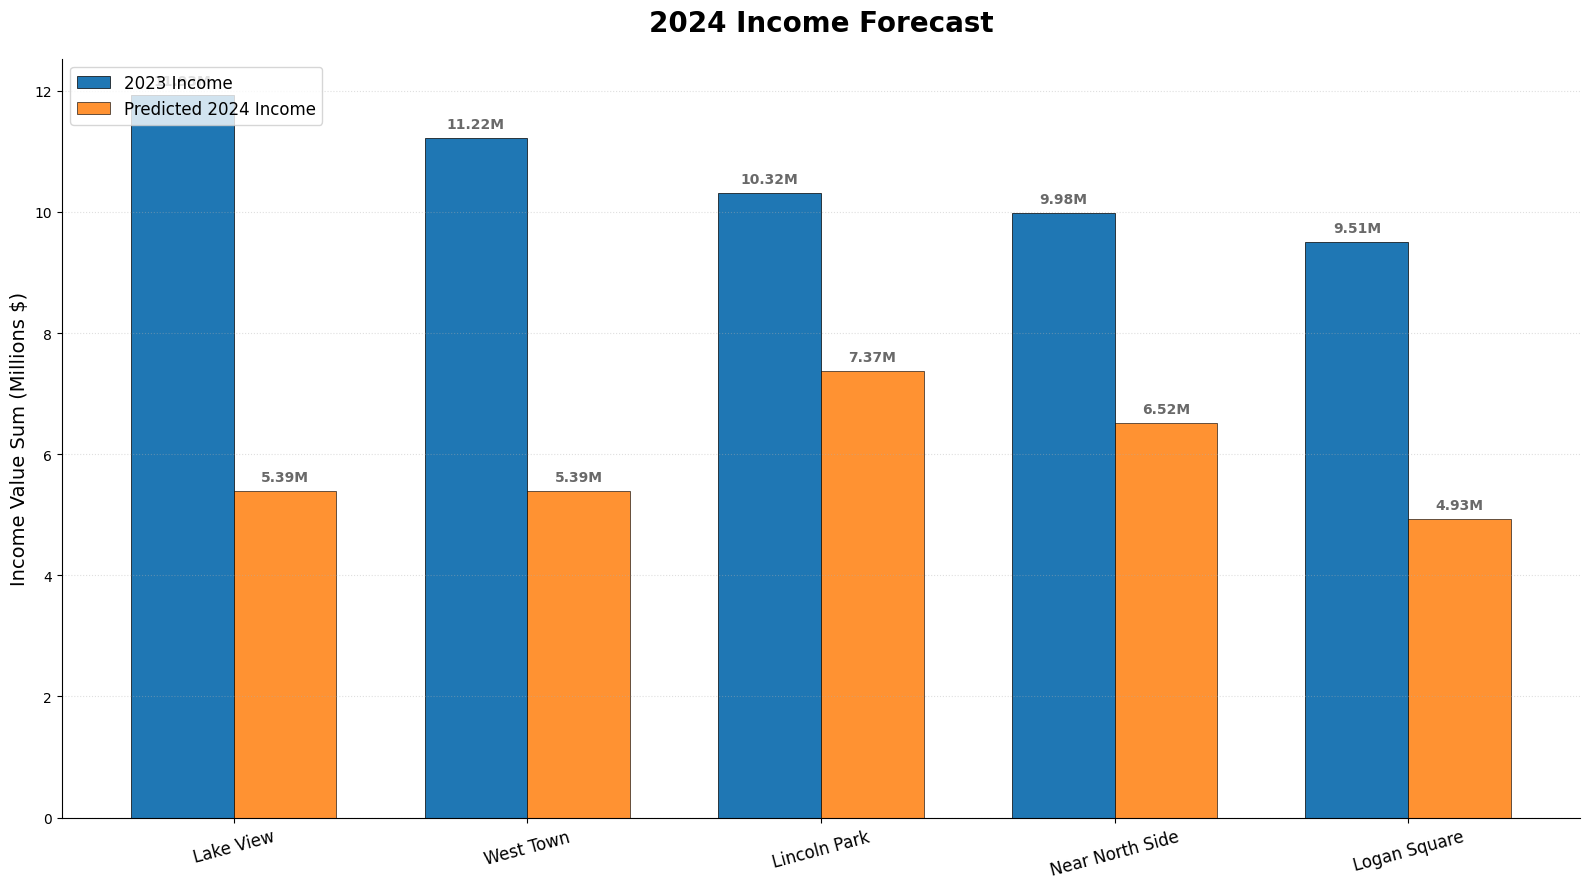

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Assumptions ---
# model, dataset, device, target_scaler, area_numbers must already be defined

# Set model to evaluation mode
model.eval()

# --- Use 2023 snapshot (index 2023 - start_year) ---
# Assuming dataset features are ordered by year starting from start_year
year_to_predict_index = -1
snapshot = dataset[year_to_predict_index].to(device)

with torch.no_grad():
    Y_hat_scaled = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    Y_true_scaled = snapshot.y

# --- Inverse transform ---
Y_pred_log = target_scaler.inverse_transform(Y_hat_scaled.cpu().numpy())
Y_true_log = target_scaler.inverse_transform(Y_true_scaled.cpu().numpy())

Y_pred = np.expm1(Y_pred_log)
Y_true = np.expm1(Y_true_log)

# Clean negative artifacts
Y_pred[Y_pred < 0] = 0

# --- Metrics ---
mse = mean_squared_error(Y_true, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_true, Y_pred)

print(f"Prediction for 2024 using 2023 snapshot:")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# --- Plot for selected communities ---
target_communities = {
    "Lake View": 6,
    "West Town": 24,
    "Lincoln Park": 7,
    "Near North Side": 8,
    "Logan Square": 22
}

area_to_index = {id: i for i, id in enumerate(area_numbers)}
plot_data = [data for name, id in target_communities.items() if id in area_to_index]

community_names = [name for name, id in target_communities.items() if id in area_to_index]
actual_values = [Y_true[area_to_index[id], 0] for name, id in target_communities.items() if id in area_to_index]
predicted_values = [Y_pred[area_to_index[id], 0] for name, id in target_communities.items() if id in area_to_index]

# Convert to millions
M_FACTOR = 1_000_000
actual_values = [v / M_FACTOR for v in actual_values]
predicted_values = [v / M_FACTOR for v in predicted_values]

# --- Plot ---
x = np.arange(len(community_names))
width = 0.35
COLOR_ACTUAL = '#1f77b4'
COLOR_PREDICTED = '#ff7f0e'

fig, ax = plt.subplots(figsize=(16, 9))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

rects1 = ax.bar(x - width/2, actual_values, width, label='2023 Income', color=COLOR_ACTUAL, edgecolor='black', linewidth=0.5)
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted 2024 Income', color=COLOR_PREDICTED, edgecolor='black', linewidth=0.5, alpha=0.85)

ax.set_title("2024 Income Forecast", fontsize=20, fontweight='bold', pad=20)
ax.set_ylabel("Income Value Sum (Millions $)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(community_names, rotation=15, ha="center", fontsize=12)
ax.legend(fontsize=12, loc='upper left')
ax.grid(axis='y', linestyle=':', alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}M',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold', color='dimgray')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


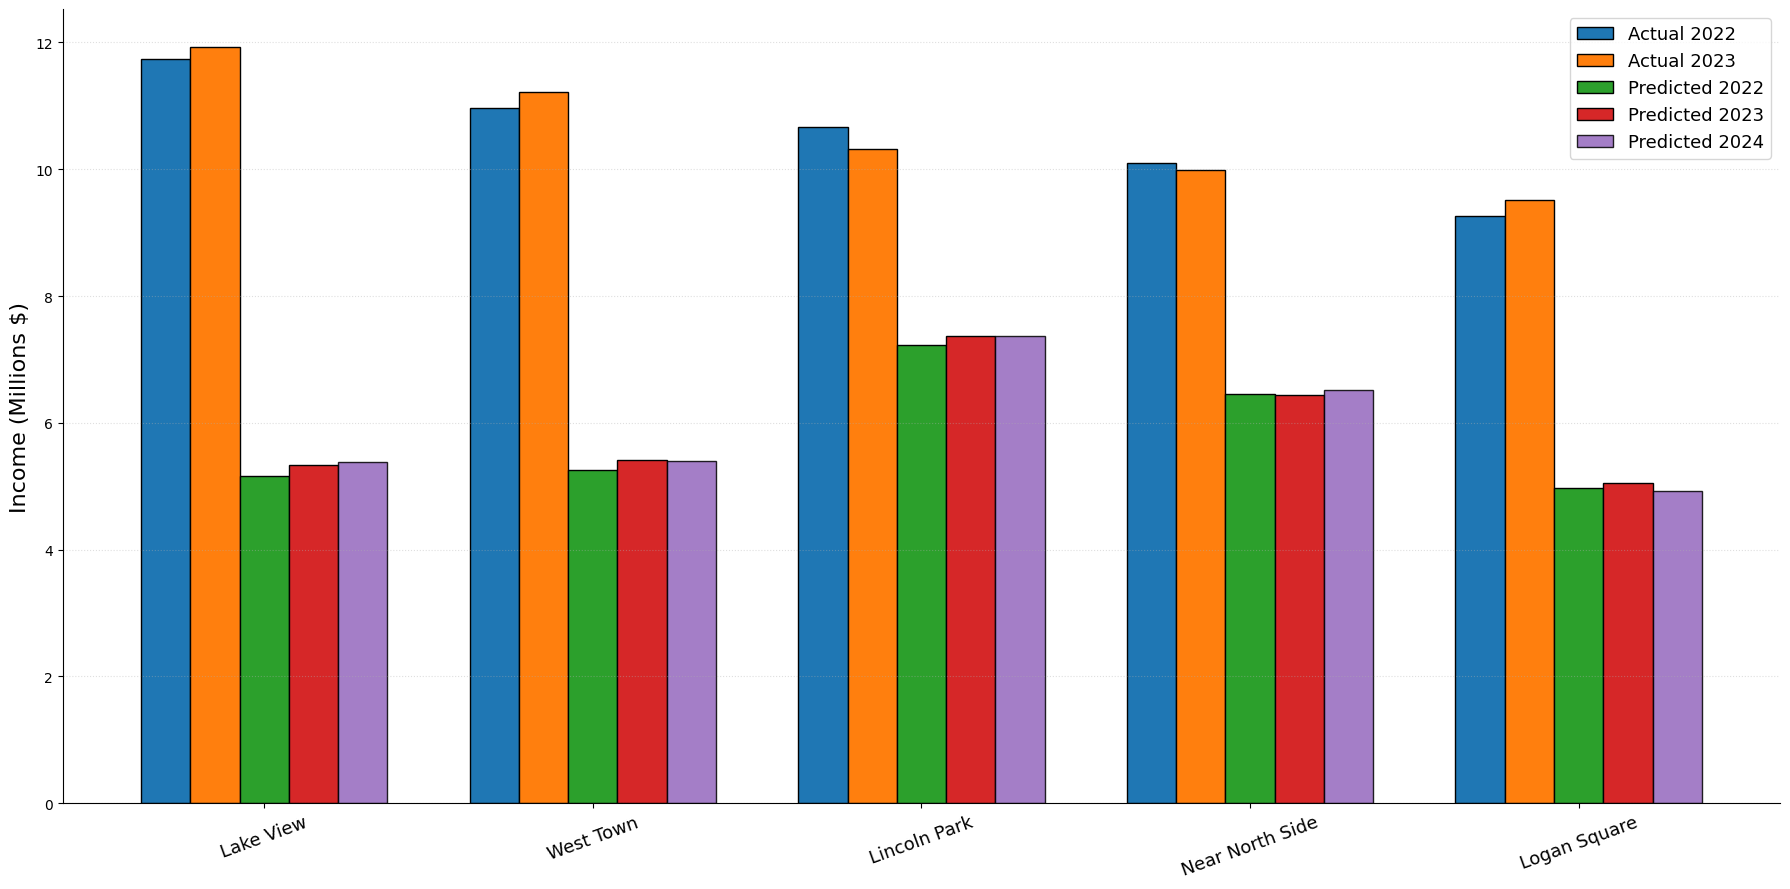

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------------------------------------
# Assumptions:
# model, dataset, device, target_scaler, area_numbers already exist
# dataset[year] returns StaticGraphTemporalSignal snapshot
# -------------------------------------------------------------

def predict_next_year(snapshot):
    """Run model for one snapshot and inverse-transform."""
    model.eval()
    with torch.no_grad():
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        y_true = snapshot.y

    # undo scaling
    y_hat_log = target_scaler.inverse_transform(y_hat.cpu().numpy())
    y_true_log = target_scaler.inverse_transform(y_true.cpu().numpy())

    y_hat_final = np.expm1(y_hat_log)
    y_true_final = np.expm1(y_true_log)

    y_hat_final[y_hat_final < 0] = 0
    return y_true_final, y_hat_final

# -------------------------------------------------------------
# 1) Predict 2022 using 2021
# -------------------------------------------------------------
snap_2021 = dataset[-3]   # third last = 2021
Y2022_true, Y2022_pred = predict_next_year(snap_2021)

# -------------------------------------------------------------
# 1) Predict 2023 using 2022
# -------------------------------------------------------------
snap_2022 = dataset[-2]   # second last = 2022
Y2023_true, Y2023_pred = predict_next_year(snap_2022)

# -------------------------------------------------------------
# 2) Predict 2024 using 2023
# -------------------------------------------------------------
snap_2023 = dataset[-1]   # last = 2023
Y2024_true, Y2024_pred = predict_next_year(snap_2023)


# -------------------------------------------------------------
# Choose communities
# -------------------------------------------------------------
target_communities = {
    "Lake View": 6,
    "West Town": 24,
    "Lincoln Park": 7,
    "Near North Side": 8,
    "Logan Square": 22
}

area_to_index = {id: i for i, id in enumerate(area_numbers)}

community_names = []
actual_2022 = []
pred_2022 = []
actual_2023 = []
pred_2023 = []
actual_2024 = []
pred_2024 = []

for name, cid in target_communities.items():
    if cid in area_to_index:
        idx = area_to_index[cid]
        community_names.append(name)
        actual_2022.append(Y2022_true[idx, 0])
        pred_2022.append(Y2022_pred[idx, 0])
        actual_2023.append(Y2023_true[idx, 0])
        pred_2023.append(Y2023_pred[idx, 0])
        actual_2024.append(Y2024_true[idx, 0])
        pred_2024.append(Y2024_pred[idx, 0])

# Convert to millions
M = 1_000_000
actual_2022 = np.array(actual_2022)/M
pred_2022   = np.array(pred_2022)/M
actual_2023 = np.array(actual_2023)/M
pred_2023   = np.array(pred_2023)/M
actual_2024 = np.array(actual_2024)/M
pred_2024   = np.array(pred_2024)/M


# -------------------------------------------------------------
# Plot: Actual + Predicted for 2023 + 2024
# -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 9))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

x = np.arange(len(community_names))
w = 0.15  # slightly smaller for 5 bars

ax.bar(x - 2*w, actual_2022, width=w, label="Actual 2022", edgecolor="black")
ax.bar(x - 1*w, actual_2023, width=w, label="Actual 2023", edgecolor="black")
ax.bar(x + 0*w, pred_2022,   width=w, label="Predicted 2022", edgecolor="black")

ax.bar(x + 1*w, pred_2023,   width=w, label="Predicted 2023", edgecolor="black")

ax.bar(x + 2*w, pred_2024,   width=w, label="Predicted 2024", edgecolor="black", alpha=0.85)

# ax.set_title("Community Income Forecast — 2022 → 2024", fontsize=22, fontweight="bold", pad=20)
ax.set_ylabel("Income (Millions $)", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(community_names, rotation=20, fontsize=13)
ax.legend(fontsize=13)

ax.grid(axis="y", linestyle=":", alpha=0.4)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [19]:
dataset[0]

Data(x=[77, 6], edge_index=[2, 394], edge_attr=[394], y=[77, 2])

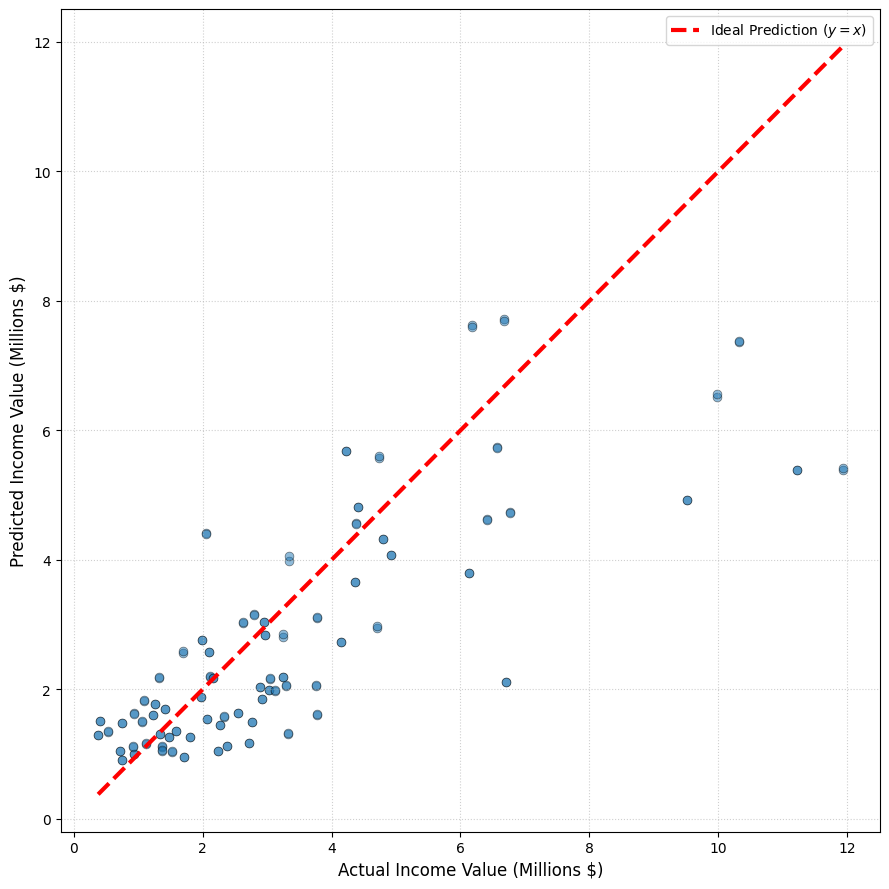

In [20]:
M_FACTOR = 1_000_000.0  # Convert to Millions

# --- Optional: Scatter plot of Actual vs. Predicted for all data points (Styled) ---
fig_scatter, ax_scatter = plt.subplots(figsize=(9, 9))
fig_scatter.patch.set_facecolor('white') # Figure background
ax_scatter.set_facecolor('white')       # Axes background

# Divide by M_FACTOR to convert to Millions
ax_scatter.scatter(Y_true / M_FACTOR, Y_pred / M_FACTOR, 
                   alpha=0.5, s=40, color=COLOR_ACTUAL, edgecolors='black', linewidths=0.5)

# Update ideal prediction line in Millions
ax_scatter.plot([Y_true.min()/M_FACTOR, Y_true.max()/M_FACTOR], 
                [Y_true.min()/M_FACTOR, Y_true.max()/M_FACTOR], 
                'r--', lw=3, label="Ideal Prediction ($y=x$)")

# ax_scatter.set_title("Actual vs. Predicted Values (Last Snapshot - All Nodes)", fontsize=16, fontweight='bold')
ax_scatter.set_xlabel("Actual Income Value (Millions $)", fontsize=12)
ax_scatter.set_ylabel("Predicted Income Value (Millions $)", fontsize=12)
ax_scatter.legend(fontsize=10)
ax_scatter.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()

plt.savefig("actual_vs_predicted_income_millions.pdf", bbox_inches='tight')
plt.show()


In [21]:
print("Train max:", train_targets_combined.max())
print("Test max:", np.log1p(targets_df["value_sum"].to_numpy()).max())


Train max: 16.145296
Test max: 16.294729144683295


Starting model evaluation on the test set...
Collected predictions for 3 test snapshots.
Data successfully inverse-transformed to original scale.

--- Evaluation Metrics (Unnormalized Scale) ---
Mean Squared Error (MSE):  2662474711040.0000
Root Mean Squared Error (RMSE): 1631709.1250
Mean Absolute Error (MAE): 1090569.1250
------------------------------------------


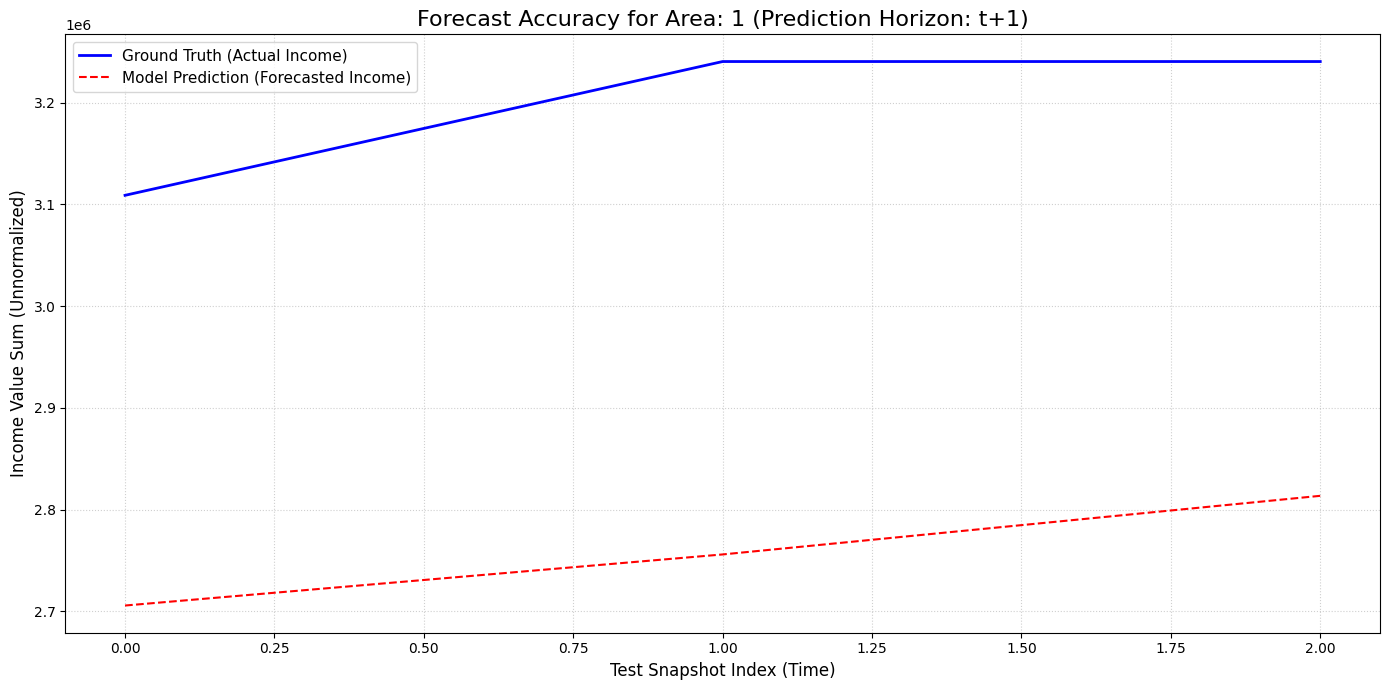

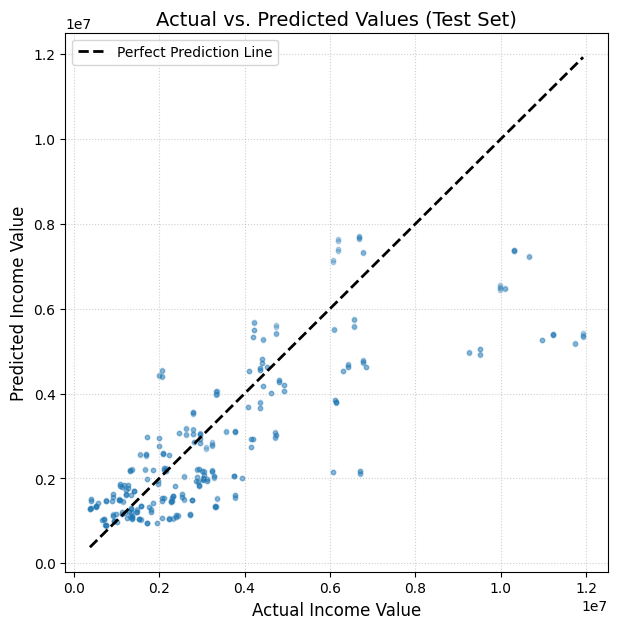

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- ASSUMPTIONS ---
# The following variables MUST be defined in your environment from previous steps:
# 1. model: The trained IncomeTGCN PyTorch model.
# 2. dataset: The StaticGraphTemporalSignal object containing all data.
# 3. test_mask: The boolean NumPy array indicating test snapshots.
# 4. device: The device ('cuda' or 'cpu') the model is running on.
# 5. target_scaler: The fitted sklearn MinMaxScaler used for targets.
# 6. area_numbers: A list/array of area identifiers (used for visualization labels).
# --------------------

# Set the model to evaluation mode
model.eval()

preds = []
labels = []

print("Starting model evaluation on the test set...")

# --- 1. Prediction Loop ---
# Collect predictions and ground truth values for all test snapshots
for t, snapshot in enumerate(dataset):
    # Only process test snapshots
    if test_mask[t]:
        # Move snapshot to the correct device
        snapshot = snapshot.to(device)

        # Disable gradient calculations during evaluation
        with torch.no_grad():
            x = snapshot.x
            edge_index = snapshot.edge_index
            edge_weight = snapshot.edge_attr
            y = snapshot.y

            y_hat = model(x, edge_index, edge_weight)

            # Store results
            preds.append(y_hat)
            labels.append(y)

print(f"Collected predictions for {len(preds)} test snapshots.")

# --- 2. Data Preparation for Inverse Transform ---

# Concatenate all tensors into single NumPy arrays, moving them to CPU first
# Shape: [Total Test Nodes * Total Test Snapshots, Output Timesteps] (e.g., [6850, 12])
Y_pred_scaled = torch.cat(preds, dim=0).cpu().detach().numpy()
Y_true_scaled = torch.cat(labels, dim=0).cpu().detach().numpy()

# --- 3. Inverse Transformation ---

# Inverse transform scaling (MinMax)
Y_pred_log = target_scaler.inverse_transform(Y_pred_scaled)
Y_true_log = target_scaler.inverse_transform(Y_true_scaled)

# Inverse transform Log1p (np.expm1) to get real, unnormalized values
Y_pred = np.expm1(Y_pred_log)
Y_true = np.expm1(Y_true_log)

# Clean up any potential negative floating-point artifacts after expm1
Y_pred[Y_pred < 0] = 0

print("Data successfully inverse-transformed to original scale.")

# --- 4. Metric Calculation ---

mse = mean_squared_error(Y_true, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_true, Y_pred)

print("\n--- Evaluation Metrics (Unnormalized Scale) ---")
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print("------------------------------------------")

# --- 5. Visualization ---

# Determine the number of time steps and nodes
num_test_steps = Y_true.shape[0] // len(area_numbers)
num_nodes = len(area_numbers)
num_output_timesteps = Y_true.shape[1] # e.g., 1

# Reshape Y_true and Y_pred back to [Time Step, Node, Output Timestep]
Y_true_reshaped = Y_true.reshape(num_test_steps, num_nodes, num_output_timesteps)
Y_pred_reshaped = Y_pred.reshape(num_test_steps, num_nodes, num_output_timesteps)

# Select a Node and the Prediction Horizon to Visualize
node_index_to_plot = 0 # Example: Look at the first node
prediction_horizon_index = 0 # Example: Look at the prediction for the immediate next time step (t+1)

node_id = area_numbers[node_index_to_plot]

# Extract the time series for the selected node and prediction horizon
y_true_ts = Y_true_reshaped[:, node_index_to_plot, prediction_horizon_index]
y_pred_ts = Y_pred_reshaped[:, node_index_to_plot, prediction_horizon_index]

plt.figure(figsize=(14, 7))
plt.plot(y_true_ts, label="Ground Truth (Actual Income)", color='blue', linewidth=2)
plt.plot(y_pred_ts, label="Model Prediction (Forecasted Income)", color='red', linestyle='--')
plt.title(f"Forecast Accuracy for Area: {node_id} (Prediction Horizon: t+{prediction_horizon_index + 1})", fontsize=16)
plt.xlabel("Test Snapshot Index (Time)", fontsize=12)
plt.ylabel("Income Value Sum (Unnormalized)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Optional: Scatter plot of Actual vs. Predicted for all data points ---
plt.figure(figsize=(7, 7))
plt.scatter(Y_true, Y_pred, alpha=0.3, s=10)
plt.plot([Y_true.min(), Y_true.max()], [Y_true.min(), Y_true.max()], 'k--', lw=2, label="Perfect Prediction Line")
plt.title("Actual vs. Predicted Values (Test Set)", fontsize=14)
plt.xlabel("Actual Income Value", fontsize=12)
plt.ylabel("Predicted Income Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Epoch 0, Train Loss: 0.1456, Test Loss: 0.0796


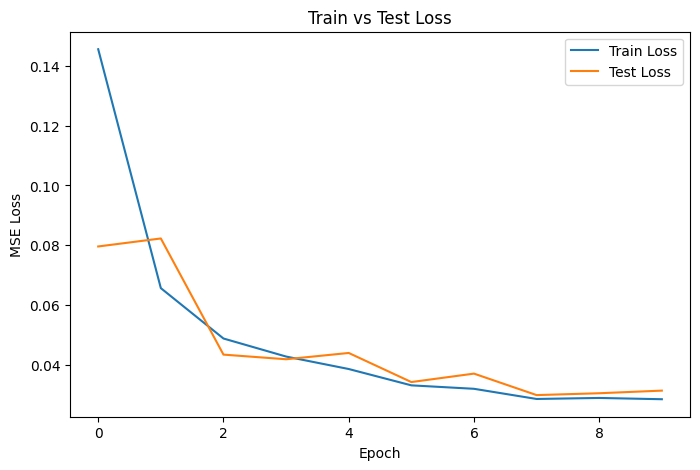

In [23]:

class IncomeTGCN(nn.Module):
    def __init__(self, node_features, hidden_size, out_features):
        super(IncomeTGCN, self).__init__()
        self.tgcn = TGCN(node_features, hidden_size)
        self.linear = nn.Linear(hidden_size, out_features)

    def forward(self, x, edge_index, edge_weight=None):
        h = self.tgcn(x, edge_index, edge_weight)
        out = self.linear(h)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IncomeTGCN(node_features=dataset[0].x.shape[1],
                   hidden_size=32,
                   out_features=dataset[0].y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop with train/test loss
train_losses = []
test_losses = []

model.train()

for epoch in range(10):
    loss_train_total = 0
    loss_test_total = 0

    for t, snapshot in enumerate(dataset):
        # 1. Move the entire snapshot object to the GPU at once
        snapshot = snapshot.to(device)

        # 2. Access tensors via dot notation
        x = snapshot.x
        edge_index = snapshot.edge_index
        edge_weight = snapshot.edge_attr
        y = snapshot.y

        optimizer.zero_grad()
        y_hat = model(x, edge_index, edge_weight)
        loss = criterion(y_hat, y)
        if train_mask[t]:
            loss.backward()
            optimizer.step()
            loss_train_total += loss.item()
        else:
            with torch.no_grad():
                loss_test_total += loss.item()

    train_losses.append(loss_train_total / max(1, sum(train_mask)))
    test_losses.append(loss_test_total / max(1, sum(test_mask)))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot train/test loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()


In [24]:

# Evaluation
model.eval()
preds = []
labels = []

for t, snapshot in enumerate(dataset):
    if train_mask[t]:
        continue

    snapshot = snapshot.to(device)

    with torch.no_grad():
        x = snapshot.x
        edge_index = snapshot.edge_index
        edge_weight = snapshot.edge_attr
        y = snapshot.y

        y_hat = model(x, edge_index, edge_weight)

        preds.append(y_hat)
        labels.append(y)

Using device: cpu
Fitting Scaler on Training Data...
Scaler Fitted. Mean: 10.8397, Var: 0.2941
Starting Training...
Epoch 0, Train Loss: 0.8891, Test Loss: 0.6901
Epoch 20, Train Loss: 0.4272, Test Loss: 0.4349
Epoch 40, Train Loss: 0.4069, Test Loss: 0.4297
Epoch 60, Train Loss: 0.3894, Test Loss: 0.4012
Epoch 80, Train Loss: 0.3813, Test Loss: 0.3879
Epoch 100, Train Loss: 0.3819, Test Loss: 0.3866
Epoch 120, Train Loss: 0.3809, Test Loss: 0.3871
Epoch 140, Train Loss: 0.3751, Test Loss: 0.3802
Epoch 160, Train Loss: 0.3740, Test Loss: 0.3772
Epoch 180, Train Loss: 0.3690, Test Loss: 0.3750


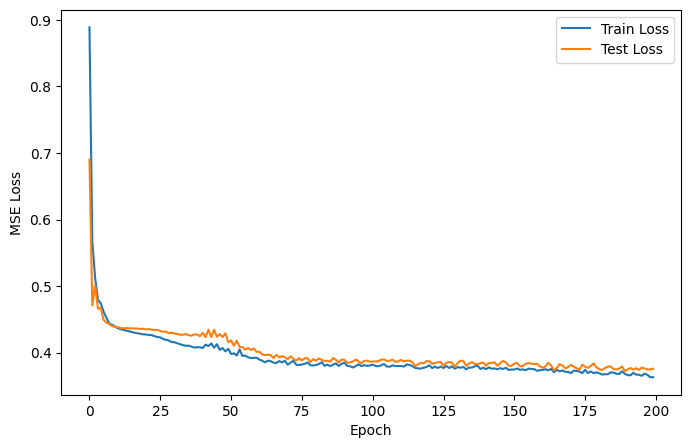


Generating Predictions...

--- 2023 MODEL PERFORMANCE ANALYSIS ---
2023 RMSE: 19,016.67
2023 MAE:  14,081.77
2023 R2 Score: 0.6017

Table: Sample of 2023 Predictions (Sorted by Error %):
Region   Actual_2023  Predicted_2023          Diff    Abs_Error  Error_Pct
   V37  14070.994141    36564.578125  22493.583984 22493.583984 159.857819
   V26  24083.000000    53825.250000  29742.250000 29742.250000 123.498940
   V18  34276.011719    71699.093750  37423.082031 37423.082031 109.181557
   V47   9936.000977    19705.490234   9769.489258  9769.489258  98.324158
   V45  21465.992188    34918.781250  13452.789062 13452.789062  62.670242
   V20  42829.007812    68382.046875  25553.039062 25553.039062  59.662926
   V49  59260.019531    25277.285156 -33982.734375 33982.734375  57.345127
   V57  30345.007812    47517.488281  17172.480469 17172.480469  56.590797
    V9  29963.992188    46578.847656  16614.855469 16614.855469  55.449402
   V25 146152.000000    66171.828125 -79980.171875 79980.17187

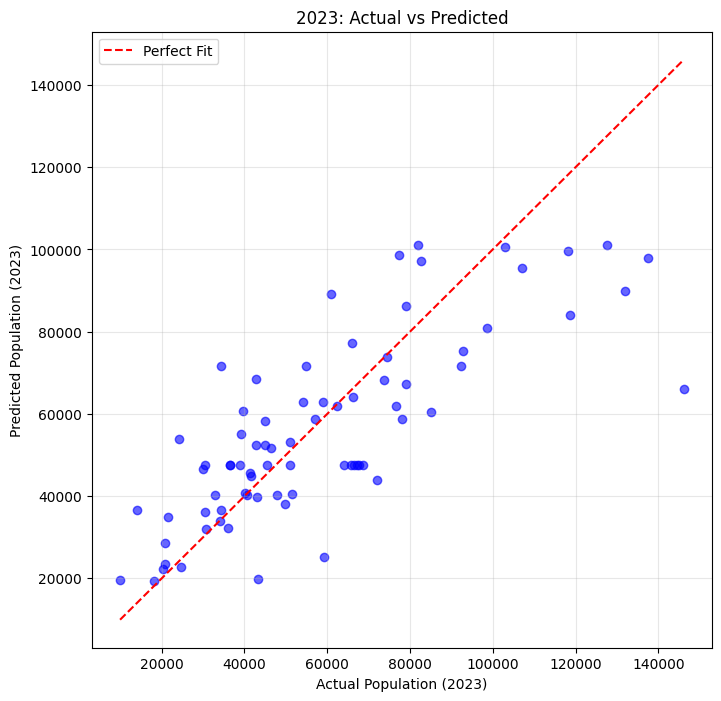

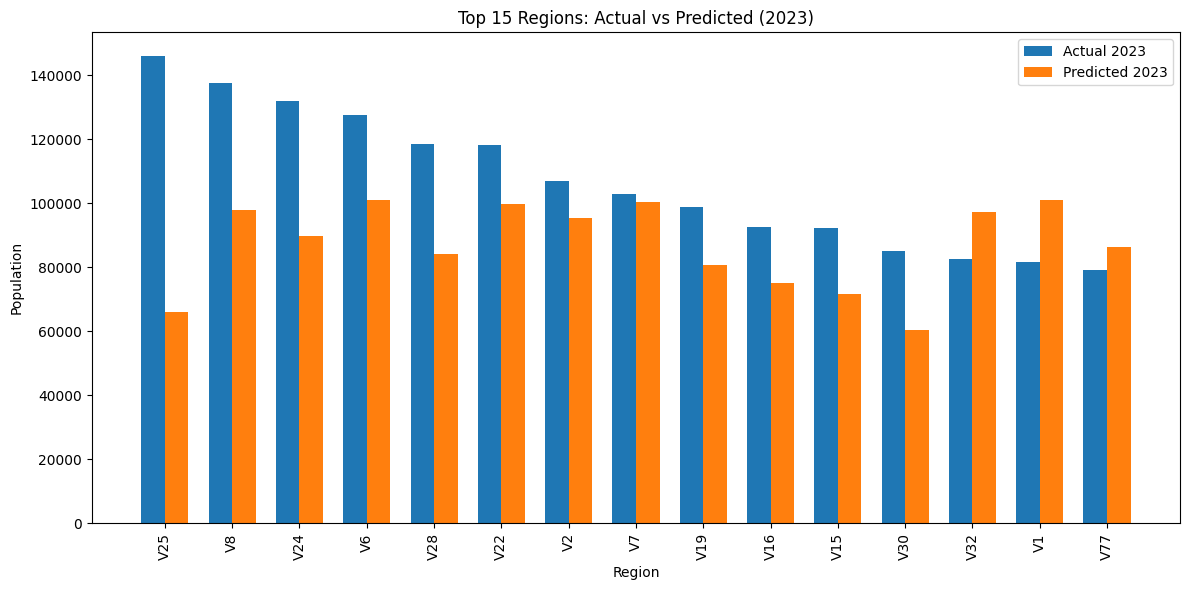


--- PREDICTING POPULATION FOR 2024 ---

Top 5 Regions by Predicted 2024 Population:
Region  2023_Actual  2024_Predicted  Growth_Pct
    V6       127630   101996.578125  -20.084167
    V7       102984   100518.734375   -2.393834
    V1        81820    99870.304688   22.060993
   V32        82577    99252.179688   20.193492
   V22       118197    99249.156250  -16.030732


In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN
import torch_geometric
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- CONFIGURATION ---
data_root_dir_path = Path(r"/kaggle/input")
category_name = "Total Population"
description = "All"
data_type = "acs"
start_year = 2015
end_year = 2023
train_test_split_year = 2020 # Years <= 2020 are Train, > 2020 are Test

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. LOAD ADJACENCY MATRIX ---
adj_matrix_file_stem = "_".join([
    category_name.lower().replace(" ", "_"),
    data_type,
    "adj_matrix",
    description.lower().replace(" ", "_"),
])
adj_matrix_file_name = f"{adj_matrix_file_stem}.csv"
population_dir_path = data_root_dir_path / "total-population-acs-sum-results"
adj_matrix_file_path = population_dir_path / adj_matrix_file_name

assert adj_matrix_file_path.exists(), f"File not found: {adj_matrix_file_path}"

adj_matrix_df = pd.read_csv(adj_matrix_file_path)
adj_matrix = adj_matrix_df.to_numpy()

# Convert to PyG Edge Index
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# --- 2. SETUP FILE PATHS ---
item_sum_results_file_paths = {}
for year in range(start_year, end_year + 1):
    item_sum_results_file_stem = "_".join([
        category_name.lower().replace(" ", "_"),
        data_type,
        "item_sum_results",
        description.lower().replace(" ", "_"),
        f"{year}",
    ])
    item_sum_results_file_name = f"{item_sum_results_file_stem}.csv"
    item_sum_results_file_path = population_dir_path / item_sum_results_file_name
    
    assert item_sum_results_file_path.exists(), f"Missing year {year}"
    item_sum_results_file_paths[year] = item_sum_results_file_path

# --- 3. DATA PREPROCESSING (LOG + SCALING) ---

# STEP A: Fit Scaler on TRAINING DATA ONLY
print("Fitting Scaler on Training Data...")
train_vals_collect = []

for year in range(start_year, train_test_split_year + 1):
    df = pd.read_csv(item_sum_results_file_paths[year])
    raw_val = df['value_sum'].values
    log_val = np.log1p(raw_val)
    train_vals_collect.append(log_val)

scaler = StandardScaler()
train_data_stack = np.concatenate(train_vals_collect).reshape(-1, 1)
scaler.fit(train_data_stack)

print(f"Scaler Fitted. Mean: {scaler.mean_[0]:.4f}, Var: {scaler.var_[0]:.4f}")

# STEP B: Transform ALL Data
X_list = []
y_list = []
train_mask = []

# Loop creates Input->Target pairs. 
# Last pair is Input(2022) -> Target(2023)
for year in range(start_year, end_year):
    curr_path = item_sum_results_file_paths[year]
    next_path = item_sum_results_file_paths[year + 1]
    
    val_curr = pd.read_csv(curr_path)['value_sum'].values
    val_next = pd.read_csv(next_path)['value_sum'].values

    val_curr_log = np.log1p(val_curr).reshape(-1, 1)
    val_next_log = np.log1p(val_next).reshape(-1, 1)
    
    x_t = scaler.transform(val_curr_log).astype(np.float32)
    y_t = scaler.transform(val_next_log).astype(np.float32)

    X_list.append(x_t)
    y_list.append(y_t)
    
    train_mask.append(year <= train_test_split_year)

train_mask = np.array(train_mask)
test_mask = ~train_mask

# --- 4. DATASET & MODEL ---
dataset = StaticGraphTemporalSignal(edge_index=edge_index,
                                    edge_weight=None,
                                    features=X_list,
                                    targets=y_list)

class PopulationTGCN(nn.Module):
    def __init__(self, node_features, hidden_size):
        super(PopulationTGCN, self).__init__()
        self.tgcn = TGCN(node_features, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index, edge_weight=None):
        h = self.tgcn(x, edge_index, edge_weight)
        h = F.relu(h) 
        out = self.linear(h)
        return out

model = PopulationTGCN(node_features=1, hidden_size=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# --- 5. TRAINING LOOP ---
train_losses = []
test_losses = []

print("Starting Training...")
model.train()

for epoch in range(200):
    loss_train_total = 0
    loss_test_total = 0

    for t, snapshot in enumerate(dataset):
        snapshot = snapshot.to(device)
        optimizer.zero_grad()
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss = criterion(y_hat, snapshot.y)
        
        if train_mask[t]:
            loss.backward()
            optimizer.step()
            loss_train_total += loss.item()
        else:
            with torch.no_grad():
                loss_test_total += loss.item()

    train_losses.append(loss_train_total / max(1, sum(train_mask)))
    test_losses.append(loss_test_total / max(1, sum(test_mask)))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# --- 6. EVALUATION (ALL YEARS) ---
model.eval()
preds_real = []   
actuals_real = [] 

print("\nGenerating Predictions...")
for snapshot in dataset:
    snapshot = snapshot.to(device)
    with torch.no_grad():
        y_hat_scaled = model(snapshot.x, snapshot.edge_index)
        
        # Inverse Transform Pipeline
        y_hat_log = scaler.inverse_transform(y_hat_scaled.cpu().numpy())
        y_true_log = scaler.inverse_transform(snapshot.y.cpu().numpy())
        
        y_hat_real = np.expm1(y_hat_log)
        y_true_real = np.expm1(y_true_log)
        
        preds_real.append(y_hat_real)
        actuals_real.append(y_true_real)

# --- 7. ANALYSIS: 2023 GT vs PREDICTION ---
print("\n" + "="*40)
print("--- 2023 MODEL PERFORMANCE ANALYSIS ---")
print("="*40)

# The last item in our dataset corresponds to Target Year 2023
# (Because loop ran up to end_year-1 as input)
idx_2023 = -1 
pred_2023 = preds_real[idx_2023].flatten()
gt_2023 = actuals_real[idx_2023].flatten()
regions = list(adj_matrix_df.columns)

# 1. Create Comparison Table
df_2023_compare = pd.DataFrame({
    'Region': regions,
    'Actual_2023': gt_2023,
    'Predicted_2023': pred_2023
})
df_2023_compare['Diff'] = df_2023_compare['Predicted_2023'] - df_2023_compare['Actual_2023']
df_2023_compare['Abs_Error'] = df_2023_compare['Diff'].abs()
df_2023_compare['Error_Pct'] = (df_2023_compare['Abs_Error'] / df_2023_compare['Actual_2023']) * 100

# 2. Print Metrics
rmse_2023 = np.sqrt(mean_squared_error(gt_2023, pred_2023))
mae_2023 = mean_absolute_error(gt_2023, pred_2023)
r2_2023 = r2_score(gt_2023, pred_2023)

print(f"2023 RMSE: {rmse_2023:,.2f}")
print(f"2023 MAE:  {mae_2023:,.2f}")
print(f"2023 R2 Score: {r2_2023:.4f}")

# 3. Print Top 10 Rows (sorted by Error)
print("\nTable: Sample of 2023 Predictions (Sorted by Error %):")
print(df_2023_compare.sort_values('Error_Pct', ascending=False).head(10).to_string(index=False))

# 4. PLOT 1: Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(8, 8))
plt.scatter(gt_2023, pred_2023, alpha=0.6, color='blue')
# Add diagonal perfect fit line
min_val = min(gt_2023.min(), pred_2023.min())
max_val = max(gt_2023.max(), pred_2023.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

plt.xlabel("Actual Population (2023)")
plt.ylabel("Predicted Population (2023)")
plt.title("2023: Actual vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. PLOT 2: Bar Plot of Top 15 Regions
# Sort by size to make chart readable
df_vis = df_2023_compare.sort_values(by='Actual_2023', ascending=False).head(15)

x = np.arange(len(df_vis))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_vis['Actual_2023'], width, label='Actual 2023')
plt.bar(x + width/2, df_vis['Predicted_2023'], width, label='Predicted 2023')

plt.xlabel('Region')
plt.ylabel('Population')
plt.title('Top 15 Regions: Actual vs Predicted (2023)')
plt.xticks(x, df_vis['Region'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# --- 8. FORECAST FUTURE (2024) ---
print("\n" + "="*40)
print(f"--- PREDICTING POPULATION FOR {end_year + 1} ---")
print("="*40)

last_year_path = item_sum_results_file_paths[end_year]
df_2023_input = pd.read_csv(last_year_path)
raw_2023 = df_2023_input['value_sum'].values

log_2023 = np.log1p(raw_2023).reshape(-1, 1)
x_2024_input = scaler.transform(log_2023).astype(np.float32)

x_2024_tensor = torch.tensor(x_2024_input).to(device)
edge_index_tensor = edge_index.to(device)

model.eval()
with torch.no_grad():
    y_hat_2024_scaled = model(x_2024_tensor, edge_index_tensor)
    y_hat_2024_log = scaler.inverse_transform(y_hat_2024_scaled.cpu().numpy())
    y_hat_2024_real = np.expm1(y_hat_2024_log)

forecast_df = pd.DataFrame({
    'Region': regions,
    '2023_Actual': raw_2023,
    '2024_Predicted': y_hat_2024_real.flatten()
})

forecast_df['Growth_Pct'] = ((forecast_df['2024_Predicted'] - forecast_df['2023_Actual']) / forecast_df['2023_Actual']) * 100

print("\nTop 5 Regions by Predicted 2024 Population:")
print(forecast_df.sort_values(by='2024_Predicted', ascending=False).head(5).to_string(index=False))

In [26]:
dataset[0]

Data(x=[77, 1], edge_index=[2, 394], y=[77, 1])

Using device: cpu
Fitting Scaler on Training Data...
Scaler Fitted. Mean: 10.8397, Var: 0.2941
Starting Training...
Epoch 0, Train Loss: 0.9089, Test Loss: 0.6876
Epoch 20, Train Loss: 0.4332, Test Loss: 0.4372
Epoch 40, Train Loss: 0.4095, Test Loss: 0.4273
Epoch 60, Train Loss: 0.4006, Test Loss: 0.4219
Epoch 80, Train Loss: 0.3857, Test Loss: 0.4057
Epoch 100, Train Loss: 0.3652, Test Loss: 0.3917
Epoch 120, Train Loss: 0.3483, Test Loss: 0.3843
Epoch 140, Train Loss: 0.3405, Test Loss: 0.3634
Epoch 160, Train Loss: 0.3292, Test Loss: 0.3771
Epoch 180, Train Loss: 0.3230, Test Loss: 0.3673


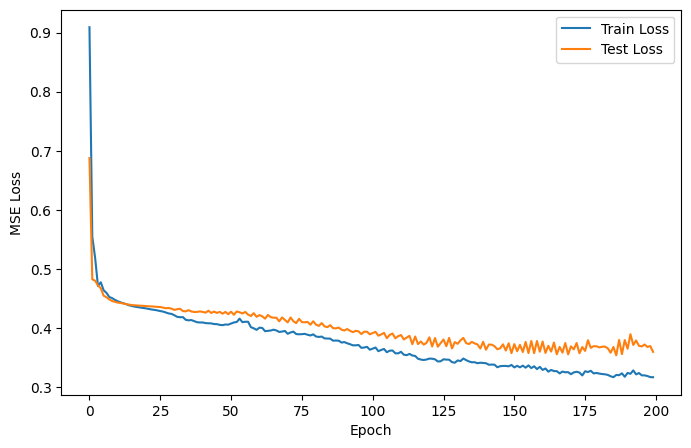


Generating Predictions...

--- 2023 MODEL PERFORMANCE ANALYSIS ---
2023 RMSE: 19,247.38
2023 MAE:  14,008.06
2023 R2 Score: 0.5920

Table: Sample of 2023 Predictions (Sorted by Error %):
Region   Actual_2023  Predicted_2023          Diff    Abs_Error  Error_Pct
   V26  24083.000000    53384.574219  29301.574219 29301.574219 121.669128
   V18  34276.011719    75423.351562  41147.339844 41147.339844 120.047043
   V37  14070.994141    29580.761719  15509.767578 15509.767578 110.225105
   V47   9936.000977    19838.714844   9902.713867  9902.713867  99.664986
   V20  42829.007812    76052.546875  33223.539062 33223.539062  77.572517
   V36  20836.996094    36603.167969  15766.171875 15766.171875  75.664322
    V9  29963.992188    50880.589844  20916.597656 20916.597656  69.805779
   V67  39752.992188    62597.675781  22844.683594 22844.683594  57.466579
   V25 146152.000000    64653.238281 -81498.765625 81498.765625  55.763020
   V38  43231.007812    19461.439453 -23769.568359 23769.56835

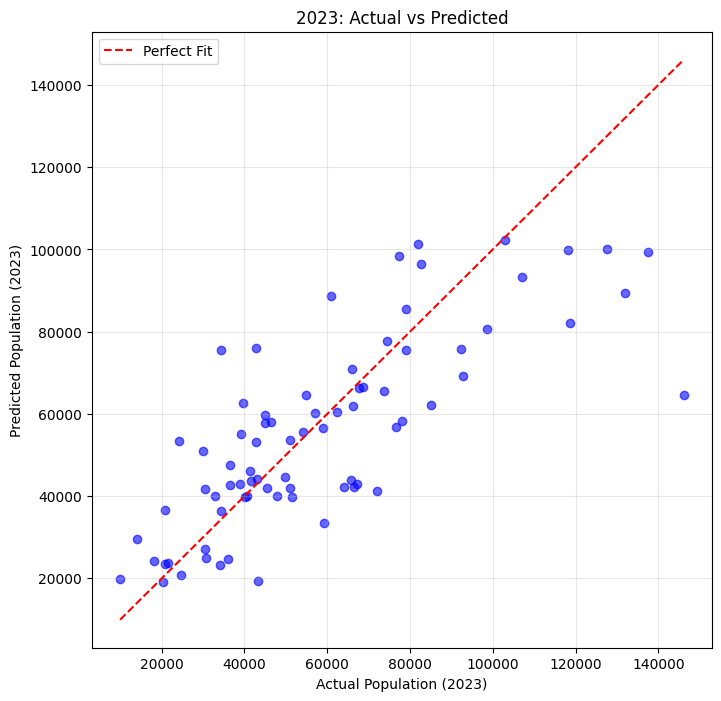

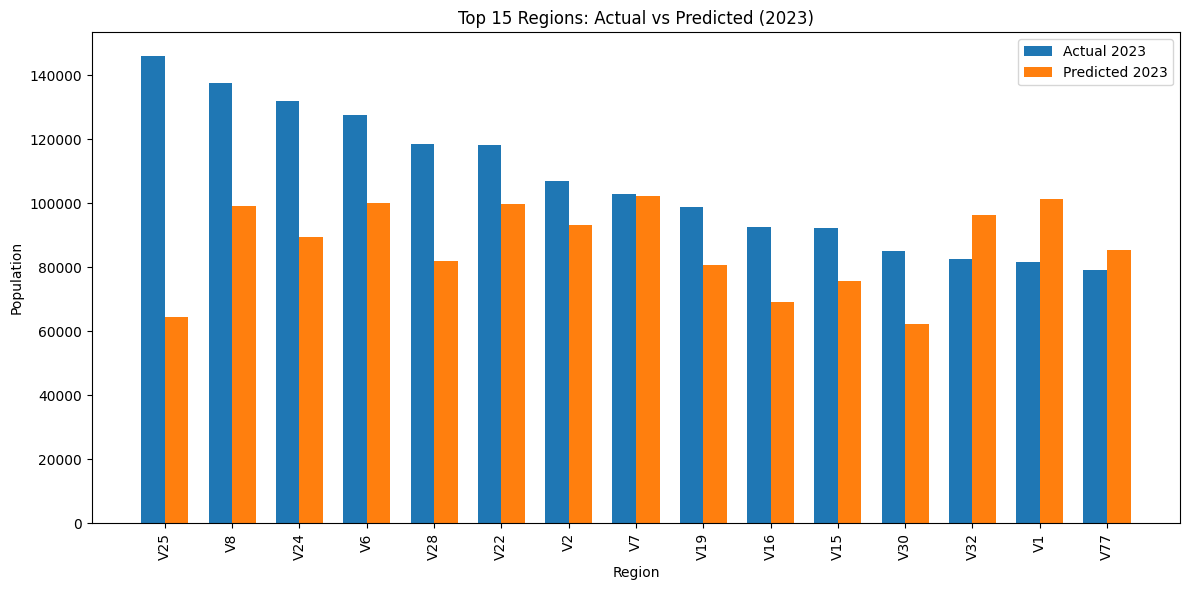


--- MODEL INTERPRETABILITY (PCA of Embeddings) ---


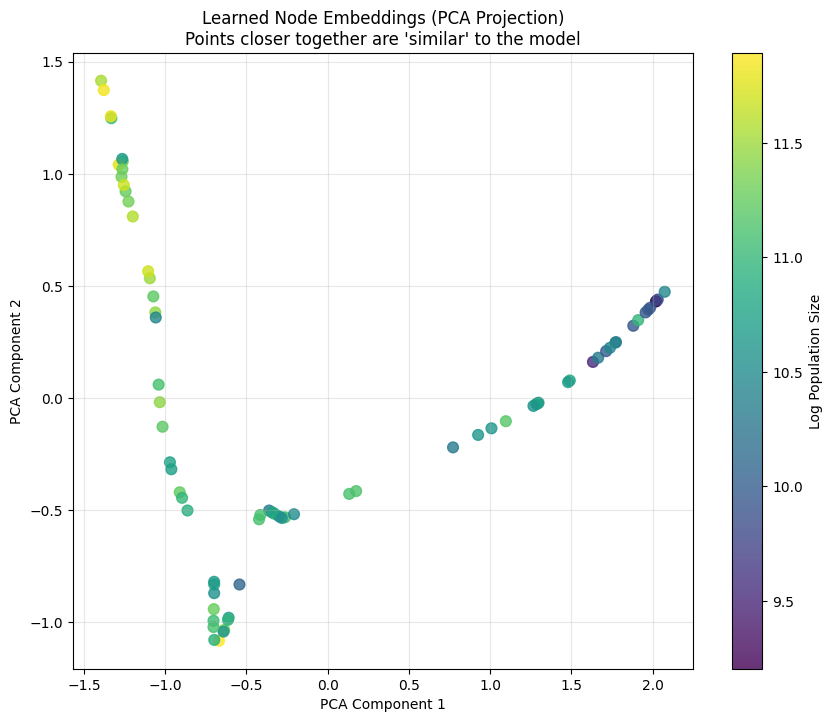


--- PREDICTING POPULATION FOR 2024 ---

Top 5 Regions by Predicted 2024 Population:
Region  2023_Actual  2024_Predicted  Growth_Pct
    V7       102984   102323.546875   -0.641316
    V6       127630   101775.812500  -20.257140
    V1        81820   100044.851562   22.274324
    V8       137610    99965.593750  -27.355865
   V32        82577    99258.335938   20.200947


In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN
import torch_geometric
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

# --- CONFIGURATION ---
data_root_dir_path = Path(r"/kaggle/input")
category_name = "Total Population"
description = "All"
data_type = "acs"
start_year = 2015
end_year = 2023
train_test_split_year = 2020 # Years <= 2020 are Train, > 2020 are Test

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. LOAD ADJACENCY MATRIX ---
adj_matrix_file_stem = "_".join([
    category_name.lower().replace(" ", "_"),
    data_type,
    "adj_matrix",
    description.lower().replace(" ", "_"),
])
adj_matrix_file_name = f"{adj_matrix_file_stem}.csv"
population_dir_path = data_root_dir_path / "total-population-acs-sum-results"
adj_matrix_file_path = population_dir_path / adj_matrix_file_name

assert adj_matrix_file_path.exists(), f"File not found: {adj_matrix_file_path}"

adj_matrix_df = pd.read_csv(adj_matrix_file_path)
adj_matrix = adj_matrix_df.to_numpy()

# Convert to PyG Edge Index
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# --- 2. SETUP FILE PATHS ---
item_sum_results_file_paths = {}
for year in range(start_year, end_year + 1):
    item_sum_results_file_stem = "_".join([
        category_name.lower().replace(" ", "_"),
        data_type,
        "item_sum_results",
        description.lower().replace(" ", "_"),
        f"{year}",
    ])
    item_sum_results_file_name = f"{item_sum_results_file_stem}.csv"
    item_sum_results_file_path = population_dir_path / item_sum_results_file_name
    
    assert item_sum_results_file_path.exists(), f"Missing year {year}"
    item_sum_results_file_paths[year] = item_sum_results_file_path

# --- 3. DATA PREPROCESSING (LOG + SCALING) ---

# STEP A: Fit Scaler on TRAINING DATA ONLY
print("Fitting Scaler on Training Data...")
train_vals_collect = []

for year in range(start_year, train_test_split_year + 1):
    df = pd.read_csv(item_sum_results_file_paths[year])
    raw_val = df['value_sum'].values
    log_val = np.log1p(raw_val)
    train_vals_collect.append(log_val)

scaler = StandardScaler()
train_data_stack = np.concatenate(train_vals_collect).reshape(-1, 1)
scaler.fit(train_data_stack)

print(f"Scaler Fitted. Mean: {scaler.mean_[0]:.4f}, Var: {scaler.var_[0]:.4f}")

# STEP B: Transform ALL Data
X_list = []
y_list = []
train_mask = []

# Loop creates Input->Target pairs. 
# Last pair is Input(2022) -> Target(2023)
for year in range(start_year, end_year):
    curr_path = item_sum_results_file_paths[year]
    next_path = item_sum_results_file_paths[year + 1]
    
    val_curr = pd.read_csv(curr_path)['value_sum'].values
    val_next = pd.read_csv(next_path)['value_sum'].values

    val_curr_log = np.log1p(val_curr).reshape(-1, 1)
    val_next_log = np.log1p(val_next).reshape(-1, 1)
    
    x_t = scaler.transform(val_curr_log).astype(np.float32)
    y_t = scaler.transform(val_next_log).astype(np.float32)

    X_list.append(x_t)
    y_list.append(y_t)
    
    train_mask.append(year <= train_test_split_year)

train_mask = np.array(train_mask)
test_mask = ~train_mask

# --- 4. DATASET & MODEL ---
dataset = StaticGraphTemporalSignal(edge_index=edge_index,
                                    edge_weight=None,
                                    features=X_list,
                                    targets=y_list)

class PopulationTGCN(nn.Module):
    def __init__(self, node_features, hidden_size):
        super(PopulationTGCN, self).__init__()
        self.tgcn = TGCN(node_features, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index, edge_weight=None, return_hidden=False):
        h = self.tgcn(x, edge_index, edge_weight)
        h = F.relu(h) 
        out = self.linear(h)
        if return_hidden:
            return out, h
        return out

model = PopulationTGCN(node_features=1, hidden_size=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# --- 5. TRAINING LOOP ---
train_losses = []
test_losses = []

print("Starting Training...")
model.train()

for epoch in range(200):
    loss_train_total = 0
    loss_test_total = 0

    for t, snapshot in enumerate(dataset):
        snapshot = snapshot.to(device)
        optimizer.zero_grad()
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss = criterion(y_hat, snapshot.y)
        
        if train_mask[t]:
            loss.backward()
            optimizer.step()
            loss_train_total += loss.item()
        else:
            with torch.no_grad():
                loss_test_total += loss.item()

    train_losses.append(loss_train_total / max(1, sum(train_mask)))
    test_losses.append(loss_test_total / max(1, sum(test_mask)))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# --- 6. EVALUATION (ALL YEARS) ---
model.eval()
preds_real = []   
actuals_real = [] 

print("\nGenerating Predictions...")
for snapshot in dataset:
    snapshot = snapshot.to(device)
    with torch.no_grad():
        y_hat_scaled = model(snapshot.x, snapshot.edge_index)
        
        # Inverse Transform Pipeline
        y_hat_log = scaler.inverse_transform(y_hat_scaled.cpu().numpy())
        y_true_log = scaler.inverse_transform(snapshot.y.cpu().numpy())
        
        y_hat_real = np.expm1(y_hat_log)
        y_true_real = np.expm1(y_true_log)
        
        preds_real.append(y_hat_real)
        actuals_real.append(y_true_real)

# --- 7. ANALYSIS: 2023 GT vs PREDICTION ---
print("\n" + "="*40)
print("--- 2023 MODEL PERFORMANCE ANALYSIS ---")
print("="*40)

# The last item in our dataset corresponds to Target Year 2023
# (Because loop ran up to end_year-1 as input)
idx_2023 = -1 
pred_2023 = preds_real[idx_2023].flatten()
gt_2023 = actuals_real[idx_2023].flatten()
regions = list(adj_matrix_df.columns)

# 1. Create Comparison Table
df_2023_compare = pd.DataFrame({
    'Region': regions,
    'Actual_2023': gt_2023,
    'Predicted_2023': pred_2023
})
df_2023_compare['Diff'] = df_2023_compare['Predicted_2023'] - df_2023_compare['Actual_2023']
df_2023_compare['Abs_Error'] = df_2023_compare['Diff'].abs()
df_2023_compare['Error_Pct'] = (df_2023_compare['Abs_Error'] / df_2023_compare['Actual_2023']) * 100

# 2. Print Metrics
rmse_2023 = np.sqrt(mean_squared_error(gt_2023, pred_2023))
mae_2023 = mean_absolute_error(gt_2023, pred_2023)
r2_2023 = r2_score(gt_2023, pred_2023)

print(f"2023 RMSE: {rmse_2023:,.2f}")
print(f"2023 MAE:  {mae_2023:,.2f}")
print(f"2023 R2 Score: {r2_2023:.4f}")

# 3. Print Top 10 Rows (sorted by Error)
print("\nTable: Sample of 2023 Predictions (Sorted by Error %):")
print(df_2023_compare.sort_values('Error_Pct', ascending=False).head(10).to_string(index=False))

# 4. PLOT 1: Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(8, 8))
plt.scatter(gt_2023, pred_2023, alpha=0.6, color='blue')
# Add diagonal perfect fit line
min_val = min(gt_2023.min(), pred_2023.min())
max_val = max(gt_2023.max(), pred_2023.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

plt.xlabel("Actual Population (2023)")
plt.ylabel("Predicted Population (2023)")
plt.title("2023: Actual vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. PLOT 2: Bar Plot of Top 15 Regions
# Sort by size to make chart readable
df_vis = df_2023_compare.sort_values(by='Actual_2023', ascending=False).head(15)

x = np.arange(len(df_vis))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_vis['Actual_2023'], width, label='Actual 2023')
plt.bar(x + width/2, df_vis['Predicted_2023'], width, label='Predicted 2023')

plt.xlabel('Region')
plt.ylabel('Population')
plt.title('Top 15 Regions: Actual vs Predicted (2023)')
plt.xticks(x, df_vis['Region'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# --- 8. MODEL INTERPRETABILITY (VISUALIZE HIDDEN STATE) ---
print("\n" + "="*40)
print("--- MODEL INTERPRETABILITY (PCA of Embeddings) ---")
print("="*40)

# 1. Get hidden state 'h' from the last available snapshot (2023 Target)
snapshot_2023 = dataset[-1].to(device)
with torch.no_grad():
    _, hidden_state = model(snapshot_2023.x, snapshot_2023.edge_index, return_hidden=True)
    embeddings = hidden_state.cpu().numpy() # Shape: (Num_Nodes, 32)

# 2. Reduce to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# 3. Plot
plt.figure(figsize=(10, 8))
# Color points by Actual Population Size (Log Scale for better color spread)
pop_size_log = np.log1p(df_2023_compare['Actual_2023'].values)

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=pop_size_log, cmap='viridis', alpha=0.8, s=60)
plt.colorbar(scatter, label="Log Population Size")
plt.title("Learned Node Embeddings (PCA Projection)\nPoints closer together are 'similar' to the model")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, alpha=0.3)
plt.show()

# --- 9. FORECAST FUTURE (2024) ---
print("\n" + "="*40)
print(f"--- PREDICTING POPULATION FOR {end_year + 1} ---")
print("="*40)

last_year_path = item_sum_results_file_paths[end_year]
df_2023_input = pd.read_csv(last_year_path)
raw_2023 = df_2023_input['value_sum'].values

log_2023 = np.log1p(raw_2023).reshape(-1, 1)
x_2024_input = scaler.transform(log_2023).astype(np.float32)

x_2024_tensor = torch.tensor(x_2024_input).to(device)
edge_index_tensor = edge_index.to(device)

model.eval()
with torch.no_grad():
    y_hat_2024_scaled = model(x_2024_tensor, edge_index_tensor)
    y_hat_2024_log = scaler.inverse_transform(y_hat_2024_scaled.cpu().numpy())
    y_hat_2024_real = np.expm1(y_hat_2024_log)

forecast_df = pd.DataFrame({
    'Region': regions,
    '2023_Actual': raw_2023,
    '2024_Predicted': y_hat_2024_real.flatten()
})

forecast_df['Growth_Pct'] = ((forecast_df['2024_Predicted'] - forecast_df['2023_Actual']) / forecast_df['2023_Actual']) * 100

print("\nTop 5 Regions by Predicted 2024 Population:")
print(forecast_df.sort_values(by='2024_Predicted', ascending=False).head(5).to_string(index=False))

Using device: cpu
Fitting Scaler on Training Data...
Scaler Fitted. Mean: 10.8397, Var: 0.2941
Starting Training...
Epoch 0, Train Loss: 0.8756, Test Loss: 0.6509
Epoch 20, Train Loss: 0.4353, Test Loss: 0.4383
Epoch 40, Train Loss: 0.4239, Test Loss: 0.4338
Epoch 60, Train Loss: 0.4120, Test Loss: 0.4239
Epoch 80, Train Loss: 0.3958, Test Loss: 0.4097
Epoch 100, Train Loss: 0.3841, Test Loss: 0.4021
Epoch 120, Train Loss: 0.3647, Test Loss: 0.3917
Epoch 140, Train Loss: 0.3332, Test Loss: 0.3656
Epoch 160, Train Loss: 0.3214, Test Loss: 0.3594
Epoch 180, Train Loss: 0.3152, Test Loss: 0.3623


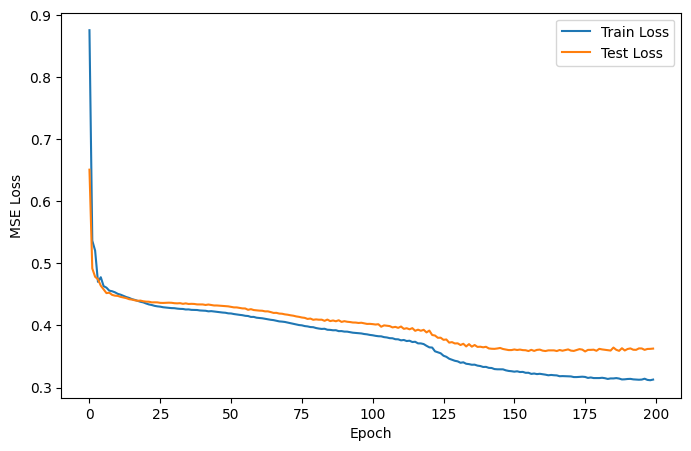


Generating Predictions...

--- 2023 MODEL PERFORMANCE ANALYSIS ---
2023 RMSE: 19,396.99
2023 MAE:  13,884.12
2023 R2 Score: 0.5856

Table: Sample of 2023 Predictions (Sorted by Error %):
Region   Actual_2023  Predicted_2023          Diff    Abs_Error  Error_Pct
   V18  34276.011719    75466.593750  41190.582031 41190.582031 120.173203
   V26  24083.000000    52622.261719  28539.261719 28539.261719 118.503761
   V37  14070.994141    27895.609375  13824.615234 13824.615234  98.249031
   V36  20836.996094    37406.011719  16569.015625 16569.015625  79.517296
   V47   9936.000977    17087.492188   7151.491211  7151.491211  71.975548
   V20  42829.007812    73123.429688  30294.421875 30294.421875  70.733421
   V38  43231.007812    16918.503906 -26312.503906 26312.503906  60.864891
    V9  29963.992188    48033.214844  18069.222656 18069.222656  60.303123
   V25 146152.000000    63929.066406 -82222.937500 82222.937500  56.258511
   V67  39752.992188    61629.933594  21876.941406 21876.94140

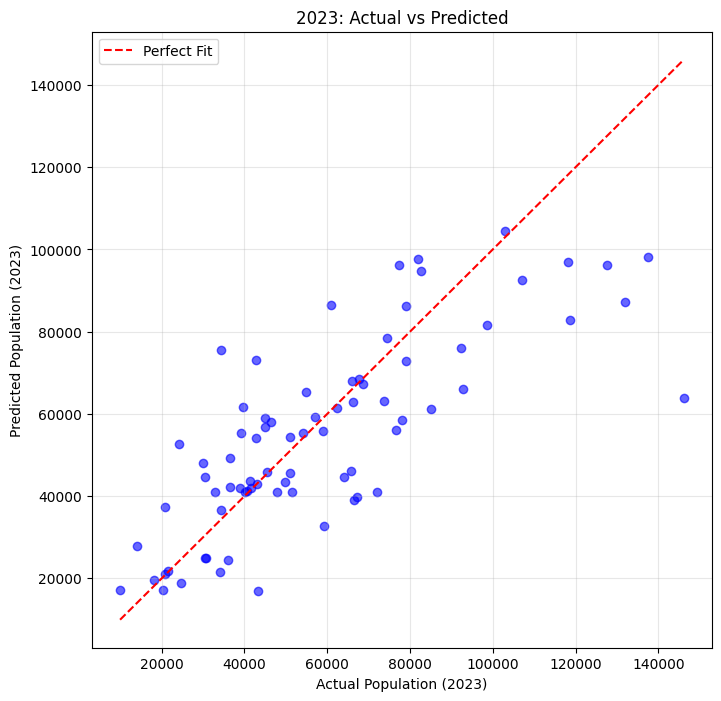


--- MODEL ARCHITECTURE DIAGRAM ---


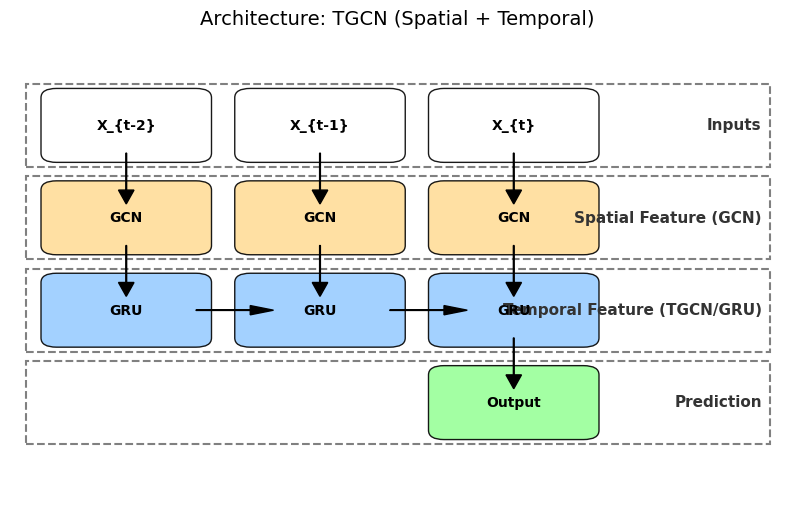


--- MODEL INTERPRETABILITY (PCA of Embeddings) ---


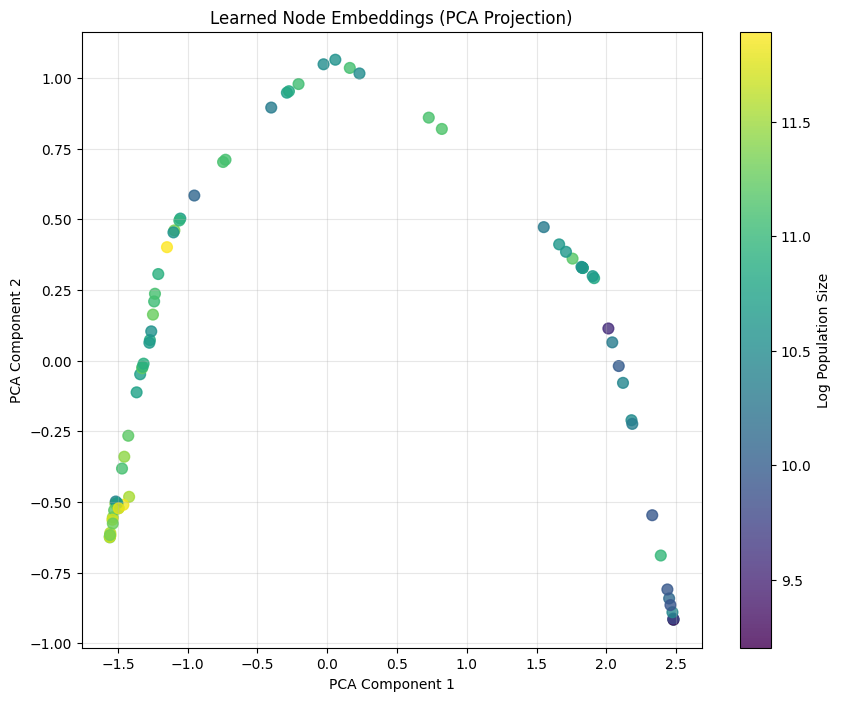


--- PREDICTING POPULATION FOR 2024 ---

Top 5 Regions by Predicted 2024 Population:
Region  2023_Actual  2024_Predicted  Growth_Pct
    V7       102984   104239.773438    1.219387
    V8       137610    99303.312500  -27.837139
    V6       127630    97469.648438  -23.631083
    V1        81820    96987.945312   18.538188
   V32        82577    96545.710938   16.915983


In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import TGCN
import torch_geometric
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

# --- CONFIGURATION ---
data_root_dir_path = Path(r"/kaggle/input")
category_name = "Total Population"
description = "All"
data_type = "acs"
start_year = 2015
end_year = 2023
train_test_split_year = 2020 # Years <= 2020 are Train, > 2020 are Test

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. LOAD ADJACENCY MATRIX ---
adj_matrix_file_stem = "_".join([
    category_name.lower().replace(" ", "_"),
    data_type,
    "adj_matrix",
    description.lower().replace(" ", "_"),
])
adj_matrix_file_name = f"{adj_matrix_file_stem}.csv"
population_dir_path = data_root_dir_path / "total-population-acs-sum-results"
adj_matrix_file_path = population_dir_path / adj_matrix_file_name

assert adj_matrix_file_path.exists(), f"File not found: {adj_matrix_file_path}"

adj_matrix_df = pd.read_csv(adj_matrix_file_path)
adj_matrix = adj_matrix_df.to_numpy()

# Convert to PyG Edge Index
edge_index = torch_geometric.utils.dense_to_sparse(torch.tensor(adj_matrix, dtype=torch.float))[0]

# --- 2. SETUP FILE PATHS ---
item_sum_results_file_paths = {}
for year in range(start_year, end_year + 1):
    item_sum_results_file_stem = "_".join([
        category_name.lower().replace(" ", "_"),
        data_type,
        "item_sum_results",
        description.lower().replace(" ", "_"),
        f"{year}",
    ])
    item_sum_results_file_name = f"{item_sum_results_file_stem}.csv"
    item_sum_results_file_path = population_dir_path / item_sum_results_file_name
    
    assert item_sum_results_file_path.exists(), f"Missing year {year}"
    item_sum_results_file_paths[year] = item_sum_results_file_path

# --- 3. DATA PREPROCESSING (LOG + SCALING) ---

# STEP A: Fit Scaler on TRAINING DATA ONLY
print("Fitting Scaler on Training Data...")
train_vals_collect = []

for year in range(start_year, train_test_split_year + 1):
    df = pd.read_csv(item_sum_results_file_paths[year])
    raw_val = df['value_sum'].values
    log_val = np.log1p(raw_val)
    train_vals_collect.append(log_val)

scaler = StandardScaler()
train_data_stack = np.concatenate(train_vals_collect).reshape(-1, 1)
scaler.fit(train_data_stack)

print(f"Scaler Fitted. Mean: {scaler.mean_[0]:.4f}, Var: {scaler.var_[0]:.4f}")

# STEP B: Transform ALL Data
X_list = []
y_list = []
train_mask = []

# Loop creates Input->Target pairs. 
# Last pair is Input(2022) -> Target(2023)
for year in range(start_year, end_year):
    curr_path = item_sum_results_file_paths[year]
    next_path = item_sum_results_file_paths[year + 1]
    
    val_curr = pd.read_csv(curr_path)['value_sum'].values
    val_next = pd.read_csv(next_path)['value_sum'].values

    val_curr_log = np.log1p(val_curr).reshape(-1, 1)
    val_next_log = np.log1p(val_next).reshape(-1, 1)
    
    x_t = scaler.transform(val_curr_log).astype(np.float32)
    y_t = scaler.transform(val_next_log).astype(np.float32)

    X_list.append(x_t)
    y_list.append(y_t)
    
    train_mask.append(year <= train_test_split_year)

train_mask = np.array(train_mask)
test_mask = ~train_mask

# --- 4. DATASET & MODEL ---
dataset = StaticGraphTemporalSignal(edge_index=edge_index,
                                    edge_weight=None,
                                    features=X_list,
                                    targets=y_list)

class PopulationTGCN(nn.Module):
    def __init__(self, node_features, hidden_size):
        super(PopulationTGCN, self).__init__()
        self.tgcn = TGCN(node_features, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index, edge_weight=None, return_hidden=False):
        h = self.tgcn(x, edge_index, edge_weight)
        h = F.relu(h) 
        out = self.linear(h)
        if return_hidden:
            return out, h
        return out

model = PopulationTGCN(node_features=1, hidden_size=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# --- 5. TRAINING LOOP ---
train_losses = []
test_losses = []

print("Starting Training...")
model.train()

for epoch in range(200):
    loss_train_total = 0
    loss_test_total = 0

    for t, snapshot in enumerate(dataset):
        snapshot = snapshot.to(device)
        optimizer.zero_grad()
        y_hat = model(snapshot.x, snapshot.edge_index)
        loss = criterion(y_hat, snapshot.y)
        
        if train_mask[t]:
            loss.backward()
            optimizer.step()
            loss_train_total += loss.item()
        else:
            with torch.no_grad():
                loss_test_total += loss.item()

    train_losses.append(loss_train_total / max(1, sum(train_mask)))
    test_losses.append(loss_test_total / max(1, sum(test_mask)))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# --- 6. EVALUATION (ALL YEARS) ---
model.eval()
preds_real = []   
actuals_real = [] 

print("\nGenerating Predictions...")
for snapshot in dataset:
    snapshot = snapshot.to(device)
    with torch.no_grad():
        y_hat_scaled = model(snapshot.x, snapshot.edge_index)
        
        # Inverse Transform Pipeline
        y_hat_log = scaler.inverse_transform(y_hat_scaled.cpu().numpy())
        y_true_log = scaler.inverse_transform(snapshot.y.cpu().numpy())
        
        y_hat_real = np.expm1(y_hat_log)
        y_true_real = np.expm1(y_true_log)
        
        preds_real.append(y_hat_real)
        actuals_real.append(y_true_real)

# --- 7. ANALYSIS: 2023 GT vs PREDICTION ---
print("\n" + "="*40)
print("--- 2023 MODEL PERFORMANCE ANALYSIS ---")
print("="*40)

idx_2023 = -1 
pred_2023 = preds_real[idx_2023].flatten()
gt_2023 = actuals_real[idx_2023].flatten()
regions = list(adj_matrix_df.columns)

df_2023_compare = pd.DataFrame({
    'Region': regions,
    'Actual_2023': gt_2023,
    'Predicted_2023': pred_2023
})
df_2023_compare['Diff'] = df_2023_compare['Predicted_2023'] - df_2023_compare['Actual_2023']
df_2023_compare['Abs_Error'] = df_2023_compare['Diff'].abs()
df_2023_compare['Error_Pct'] = (df_2023_compare['Abs_Error'] / df_2023_compare['Actual_2023']) * 100

rmse_2023 = np.sqrt(mean_squared_error(gt_2023, pred_2023))
mae_2023 = mean_absolute_error(gt_2023, pred_2023)
r2_2023 = r2_score(gt_2023, pred_2023)

print(f"2023 RMSE: {rmse_2023:,.2f}")
print(f"2023 MAE:  {mae_2023:,.2f}")
print(f"2023 R2 Score: {r2_2023:.4f}")

print("\nTable: Sample of 2023 Predictions (Sorted by Error %):")
print(df_2023_compare.sort_values('Error_Pct', ascending=False).head(10).to_string(index=False))

plt.figure(figsize=(8, 8))
plt.scatter(gt_2023, pred_2023, alpha=0.6, color='blue')
min_val = min(gt_2023.min(), pred_2023.min())
max_val = max(gt_2023.max(), pred_2023.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
plt.xlabel("Actual Population (2023)")
plt.ylabel("Predicted Population (2023)")
plt.title("2023: Actual vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 8. MODEL ARCHITECTURE VISUALIZATION (UPDATED) ---
print("\n" + "="*40)
print("--- MODEL ARCHITECTURE DIAGRAM ---")
print("="*40)

def draw_custom_architecture():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define Layout
    num_timesteps = 3
    spacing_x = 0.25
    start_x = 0.15
    
    layer_heights = {
        "Input": 0.8,
        "GCN": 0.6,
        "GRU": 0.4,
        "Pred": 0.2
    }
    
    # Helper to draw boxes
    def draw_box(x, y, text, color, width=0.18, height=0.12):
        rect = mpatches.FancyBboxPatch(
            (x - width/2, y - height/2), width, height,
            boxstyle="round,pad=0.02",
            facecolor=color, edgecolor="black", alpha=0.9
        )
        ax.add_patch(rect)
        ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold')
        return x, y

    # Draw Containers (Dashed Lines)
    containers = [
        ("Inputs", 0.8),
        ("Spatial Feature (GCN)", 0.6),
        ("Temporal Feature (TGCN/GRU)", 0.4),
        ("Prediction", 0.2)
    ]
    
    for label, y_center in containers:
        rect = mpatches.Rectangle(
            (0.02, y_center - 0.09), 0.96, 0.18,
            fill=False, linestyle="--", edgecolor="gray", linewidth=1.5
        )
        ax.add_patch(rect)
        ax.text(0.97, y_center, label, ha='right', va='center', fontsize=11, fontweight='bold', color='#333333')

    # Draw Nodes and Connections
    prev_gru_coords = None
    
    for t in range(num_timesteps):
        x = start_x + t * spacing_x
        label_t = f"t-{num_timesteps-1-t}" if t < num_timesteps-1 else "t"
        
        # 1. Input Node
        bx, by = draw_box(x, layer_heights["Input"], f"X_{{{label_t}}}", "#ffffff") # White
        
        # 2. GCN Node
        gx, gy = draw_box(x, layer_heights["GCN"], "GCN", "#ffdd99") # Yellowish
        ax.arrow(bx, by - 0.06, 0, -0.08, head_width=0.02, fc='black', ec='black') # Input -> GCN
        
        # 3. GRU Node
        grx, gry = draw_box(x, layer_heights["GRU"], "GRU", "#99ccff") # Blueish
        ax.arrow(gx, gy - 0.06, 0, -0.08, head_width=0.02, fc='black', ec='black') # GCN -> GRU
        
        # Horizontal GRU -> GRU connection
        if prev_gru_coords:
            px, py = prev_gru_coords
            ax.arrow(px + 0.09, py, (x - px) - 0.18, 0, head_width=0.02, fc='black', ec='black')
        prev_gru_coords = (grx, gry)
        
        # 4. Output (Only for last step)
        if t == num_timesteps - 1:
            px, py = draw_box(x, layer_heights["Pred"], "Output", "#99ff99") # Green
            ax.arrow(grx, gry - 0.06, 0, -0.08, head_width=0.02, fc='black', ec='black')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title("Architecture: TGCN (Spatial + Temporal)", fontsize=14)
    plt.show()

draw_custom_architecture()

# --- 9. MODEL INTERPRETABILITY (VISUALIZE HIDDEN STATE) ---
print("\n" + "="*40)
print("--- MODEL INTERPRETABILITY (PCA of Embeddings) ---")
print("="*40)

snapshot_2023 = dataset[-1].to(device)
with torch.no_grad():
    _, hidden_state = model(snapshot_2023.x, snapshot_2023.edge_index, return_hidden=True)
    embeddings = hidden_state.cpu().numpy() # Shape: (Num_Nodes, 32)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
pop_size_log = np.log1p(df_2023_compare['Actual_2023'].values)

scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=pop_size_log, cmap='viridis', alpha=0.8, s=60)
plt.colorbar(scatter, label="Log Population Size")
plt.title("Learned Node Embeddings (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True, alpha=0.3)
plt.show()

# --- 10. FORECAST FUTURE (2024) ---
print("\n" + "="*40)
print(f"--- PREDICTING POPULATION FOR {end_year + 1} ---")
print("="*40)

last_year_path = item_sum_results_file_paths[end_year]
df_2023_input = pd.read_csv(last_year_path)
raw_2023 = df_2023_input['value_sum'].values

log_2023 = np.log1p(raw_2023).reshape(-1, 1)
x_2024_input = scaler.transform(log_2023).astype(np.float32)

x_2024_tensor = torch.tensor(x_2024_input).to(device)
edge_index_tensor = edge_index.to(device)

model.eval()
with torch.no_grad():
    y_hat_2024_scaled = model(x_2024_tensor, edge_index_tensor)
    y_hat_2024_log = scaler.inverse_transform(y_hat_2024_scaled.cpu().numpy())
    y_hat_2024_real = np.expm1(y_hat_2024_log)

forecast_df = pd.DataFrame({
    'Region': regions,
    '2023_Actual': raw_2023,
    '2024_Predicted': y_hat_2024_real.flatten()
})

forecast_df['Growth_Pct'] = ((forecast_df['2024_Predicted'] - forecast_df['2023_Actual']) / forecast_df['2023_Actual']) * 100

print("\nTop 5 Regions by Predicted 2024 Population:")
print(forecast_df.sort_values(by='2024_Predicted', ascending=False).head(5).to_string(index=False))